<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#思路" data-toc-modified-id="思路-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>思路</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#attribute-selection" data-toc-modified-id="attribute-selection-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>attribute selection</a></span></li><li><span><a href="#Outliers" data-toc-modified-id="Outliers-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Outliers</a></span></li></ul></li></ul></div>

# 思路
- 预处理 怎么找到词库?

In [6]:
from sklearn.metrics import pairwise_distances
from sklearn import metrics
from sklearn import mixture
from sklearn.cluster import KMeans
from nltk.cluster import KMeansClusterer, cosine_distance
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
import numpy as np
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_recall_fscore_support, classification_report, roc_curve, auc, precision_recall_curve
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [7]:
seeds = 1234

In [99]:
train = pd.read_json('../data/structured_train.json')
test = pd.read_json('../data/structured_test.json')

In [98]:
# train = train.groupby('label').sample(50, random_state=seeds)
# test = test.groupby('label').sample(50, random_state=seeds)

# EDA

## attribute selection

In [100]:
t = train.isnull().sum().sort_values()
not_used_cols = t[t > train.shape[0]*0.1].index.tolist()
print("not_used_cols: \n", not_used_cols)
t.to_frame().style

not_used_cols: 
 ['Distribution', 'Nntp-Posting-Host', 'NNTP-Posting-Host', 'Reply-To', 'Keywords', 'Article-I.D.', 'X-Newsreader', 'Summary', 'Originator', 'In-Reply-To', 'News-Software', 'Expires', 'In-reply-to', 'To', 'X-Disclaimer', 'Disclaimer', 'X-Mailer', 'X-Useragent', 'X-Xxdate', 'Supersedes', 'X-UserAgent', 'X-XXDate', 'Nf-From', 'Nf-ID', 'X-News-Reader', 'X-Added', 'Original-Sender', 'X-Posted-From', 'X-XXMessage-ID', 'Content-Type', 'X-Xxmessage-Id', 'Cc', 'Mime-Version', 'X-Last-Updated', 'Moderator', 'Content-Transfer-Encoding', 'date', 'X-To', 'X-Gated-By', 'X-Sender', 'X-Received', 'Return-Path', 'Nntp-Posting-User', 'X-Auth-User', 'X-X-From', 'X-Md4-Signature', 'X-Maildoor', 'X-NewsSoftware', 'MIME-Version', 'Return-Receipt-To', 'X-AltNet-ID', 'X-Cc', 'Bcc', 'X-Software', 'Posting-Front-End', 'Comments', 'X-Newssoftware', 'X-News-Software', 'X-Reader', 'X-Bytes', 'X-Copyright', 'X-Mail-Reader', 'X-Header', 'Apparently-To', 'Organisation', 'Mmdf-Warning', 'OD-Comment-To

,0
global_index,0
doc_path,0
text,0
label,0
original_idx,0
delivered_to,0
reference_two,0
reference_one,0
reply,0
to_domains,11


In [101]:
select_cols = ["global_index", "doc_path", "label", "reply", "reference_one", "reference_two",
               "Subject", "From", "Lines", "Organization", "contained_emails", "long_string", "text", "error_message"]
print("\nmay use cols: \n", select_cols)
train = train[select_cols]
test = test[select_cols]


may use cols: 
 ['global_index', 'doc_path', 'label', 'reply', 'reference_one', 'reference_two', 'Subject', 'From', 'Lines', 'Organization', 'contained_emails', 'long_string', 'text', 'error_message']


In [7]:
train.head()

,global_index,doc_path,label,reply,reference_one,reference_two,Subject,From,Lines,Organization,contained_emails,long_string,text,error_message
0,0,../../data/train\alt.atheism\49960,alt.atheism,Archive-name: atheism/resources Alt-atheism-ar...,,,Alt.Atheism FAQ: Atheist Resources,mathew <mathew@mantis.co.uk>,290,"Mantis Consultants, Cambridge. UK.","[ <figmo@netcom.com>. , archive-server@mantis...",[],From: mathew <mathew@mantis.co.uk>\nSubject: A...,NaN
1,1,../../data/train\alt.atheism\51060,alt.atheism,Archive-name: atheism/introduction Alt-atheism...,,,Alt.Atheism FAQ: Introduction to Atheism,mathew <mathew@mantis.co.uk>,646,"Mantis Consultants, Cambridge. UK.","[ <mathew@mantis.co.uk> , pgpinfo@mantis.co.u...",[iQCVAgUBK8AjRXzXN+VrOblFAQFSbwP+MHePY4g7ge8Mo...,From: mathew <mathew@mantis.co.uk>\nSubject: A...,NaN
2,2,../../data/train\alt.atheism\51119,alt.atheism,The argument goes as follows: Q-oid quotes ap...,This is a new argument to me. Could you elabo...,"Well, John has a quite different, not necessar...",Re: Gospel Dating,I3150101@dbstu1.rz.tu-bs.de (Benedikt Rosenau),93,"Technical University Braunschweig, Germany","[ <65974@mimsy.umd.edu> , mangoe@cs.umd.edu ]",[],From: I3150101@dbstu1.rz.tu-bs.de (Benedikt Ro...,NaN
3,3,../../data/train\alt.atheism\51120,alt.atheism,It sounds to me like it's just SCREAMING OUT ...,"Recently, RAs have been ordered to post a rel...",,Re: university violating separation of church/...,mathew <mathew@mantis.co.uk>,29,"Mantis Consultants, Cambridge. UK.",[dmn@kepler.unh.edu ],[],From: mathew <mathew@mantis.co.uk>\nSubject: R...,NaN
4,4,../../data/train\alt.atheism\51121,alt.atheism,Can somebody reconcile the apparent contradic...,"HOWEVER, I hate economic terrorism and politi...",,"Re: [soc.motss, et al.] ""Princeton axes matchi...",strom@Watson.Ibm.Com (Rob Strom),15,IBM Research,"[ <N4HY.93Apr5120934@harder.ccr-p.ida.org>, , ...",[],From: strom@Watson.Ibm.Com (Rob Strom)\nSubjec...,NaN


In [102]:
train.isnull().sum().sort_values().to_dict()

{'global_index': 0,
 'doc_path': 0,
 'label': 0,
 'reply': 0,
 'reference_one': 0,
 'reference_two': 0,
 'text': 0,
 'Subject': 11,
 'From': 11,
 'contained_emails': 11,
 'long_string': 11,
 'Lines': 48,
 'Organization': 491,
 'error_message': 11083}

In [103]:
train[["label","global_index", "reply", "reference_one", "reference_two",]].sample(10, random_state=116).style

,label,global_index,reply,reference_one,reference_two
8273,sci.space,8273,"In the Air Force world at least, the crisis escalates when scale models of the plane in question begin to arrive in key Senators and Congresspersons' offices. Of course it is assumed that coffee mugs and other decorative junk has been tried earlier. Spiros -- Spiros Triantafyllopoulos Software Technology, Delco Electronics 451-0815 GM Hughes Electronics, Kokomo, IN 46904 ""I post, therefore I ARMM""","A brief political/cultural item. Radio station WGMS in Washington is a classical music station with a large audience among high officials . Imagine a radio station that advertises Mercedes Benzes, diamond jewelry, expensive resorts and Trident submarines. This morning I heard a commercial for the space station project. Didn't catch the advertiser. Guess they're pulling out all the stops.",
1528,comp.os.ms-windows.misc,1528,"I think you can do this with REGEDIT, which can make changes to the OLE registration database. From Program Manager choose RUN and type REGEDIT. You do have it- its included with Windows, but not well documented. Tom","A while ago I installed SPSS for Windows as part of an evaluation. Once the evaluation was complete I duly deleted the software from my PC. Unfortunately there is still a ""ghost"" of SPSS left: when I run something like ""Write"" and go to embed an object then ""SPSS Chart"" appears on the list of objects I'm offered. I looked around all the obvious ""INI"" files without success. The next thing I tried was looking for the string ""SPSS Chart"" in every file in the Windows directory. It turned up in a file called REQ.DAT . Unfortunately the file was binary and so I didn't feel inclined to edit it. I'd welcome a solution for removing SPSS from the list of OLE servers.",
6636,sci.electronics,6636,"Have anyone some idea about how to build a cheap, low resolution video projector... .",,
4382,rec.autos,4382,"I sold my '86 Sprint last April with 95k on it. I'd driven it since the previous July, putting 20k miles on it. The sensor light used to light up regularly, starting about 5k miles after I bought it. My brother and I rebuilt the engine but used all of the original equipment, so I suppose the sensor could have used replacement. Performance did not change. Perhaps emissions increased, but how much emissions could a CA-registered 3 cylinder engine produce? That was a neat car, I held the engine block easily in one hand! Has anyone ever driven the 'Turbo' variant? Just curious... Adam Edwards","I have a 86 chevy sprint with a/c and 4doors. It's odometer turned 90k and the sensor light started blinking. I went to the dealer and he said it was a maintenance light saying I need to change the Oxygen sensor. He said, It is to be changed every 30k, but since I bought the car when it had 77k, I don't know if the same thing happened at 30k and 60k. He quoted $198 for the part and $50 to install it. The part cost $30 outside, but the mechanic I went to could not fix it saying the sensor is placed too deep in the engine parts. He suggested I wait till it malfunctions before I do anything. If anyone out there owns a chevy sprint, I want to know how they got their Oxygen sensors changed. Also, did you face any problem with fixing it without the dealer's help. Also, what are the results of the oxygen sensor malfunction. Any help would be greatly apprecisted Thanks",
5693,rec.sport.baseball,5693,"Off and on over the last several months, threads about RBIs and related topics have gotten me to thinking about how well we can predict a player's RBIs using information about his overall performance and the number of runners in scoring position that he bats with. In the Brock2 model, Bill James calculated predicted RBIs as RBI=.235 + Home Runs. This completely ignores the context, which was all that Brock2 could do, since context was unknown to it. So I thought I'd take that idea as a starting point and look how good a fit to the data you get by c

## Outliers

In [104]:
l = train['long_string'].dropna().apply(len).sort_values()
longest_idx = l[l>0].index.tolist()[-10:]
train[train.global_index.isin(longest_idx)]
# train['long_string'].sample(10).tolist()

,global_index,doc_path,label,reply,reference_one,reference_two,Subject,From,Lines,Organization,contained_emails,long_string,text,error_message
1362,1362,../../data/train\comp.os.ms-windows.misc\9704,comp.os.ms-windows.misc,"Hi, everybody: I guess my subject has said it...","P!%U]< %HUIU 'QFO0""/5DT .UV4 $$ Y SLD9&1D>SLBP...","G P---7+'U0/,PURM8MMVG<GX6%A85""45%147!14:U1<%%...",Re: More Cool BMP files??,james@dlss2 (James Cummings),1021,RedRock Development,"[ <1993Apr17.023017.17301@gmuvax2.gmu.edu> , r...",[B_:S]K'EYK/W]_?W]K/W]_?W]_?W]_?VL_6JLKPO+R\_O...,From: james@dlss2 (James Cummings)\nSubject: R...,NaN
1635,1635,../../data/train\comp.os.ms-windows.misc\9980,comp.os.ms-windows.misc,------------ Part 5 of 14 ------------ M%6M%:...,W&JVM<G)RK:UR<K>W<JVM<G)R<AM<GWMWRMO MK16MMZTR...,,roman.bmp 05/14,pwiseman@salmon.usd.edu (Cliff),957,University of South Dakota,"[ M,P$HWA=@8!SKWI_,S""B<)S<W-R>!5C<-S`HFNAIR<K)...","[M)B9R&KJZ)EVZ=+ITNKH>?7U=PGU]+""Q=?72_=""PU'GT>...",Subject: roman.bmp 05/14\nFrom: pwiseman@salmo...,NaN
1637,1637,../../data/train\comp.os.ms-windows.misc\9982,comp.os.ms-windows.misc,------------ Part 6 of 14 ------------ MAX=7H...,'AX>'AX>'AX>'AX>'AX>'AX>' GHJKN/=)Q GK!Q 7EY>...,,roman.bmp 06/14,pwiseman@salmon.usd.edu (Cliff),958,University of South Dakota,"[ M`0'UZY\WG@&>T)YU)3A&$+&]#+&NAX>'AX>'AS$Q,3%...","[MAZ)75U=7R!1KP""5A8=F>`7;UG)\&V0&>YZ>W5&$'Z]M;...",Subject: roman.bmp 06/14\nFrom: pwiseman@salmo...,NaN
1638,1638,../../data/train\comp.os.ms-windows.misc\9983,comp.os.ms-windows.misc,"------------ Part 8 of 14 ------------ M:J""N6...",'AX>'AX>'AX>'AX>'AX>'AX>'`812E0<'GIYX`5Z> `0&$...,,roman.bmp 08/14,pwiseman@salmon.usd.edu (Cliff),956,University of South Dakota,"[ MAX>'AX>'AX>'AX>'AYZ>8=#0T""L!A%<-N;@+<-NPP25...","[MAPW/HFN`LC4U-34U,AK:VLV-MD'E94'V=DV-FMKS\];6...",Subject: roman.bmp 08/14\nFrom: pwiseman@salmo...,NaN
1639,1639,../../data/train\comp.os.ms-windows.misc\9984,comp.os.ms-windows.misc,------------ Part 10 of 14 ------------ MV=E&...,"'AX>'AX>'AX>'AX=34U-34U-3,3$Q,3B8G) 'AX>'AX>'A...",,roman.bmp 10/14,pwiseman@salmon.usd.edu (Cliff),956,University of South Dakota,[ M:FIJ:FIJ:FJ@KHB24E)24G9V=G9V=G9V=G9V=G9VE)3...,"[M:J""U$$,UM/3T]F9F9`P,#7EY>NRIZWT='I0MFQ#&'AX>...",Subject: roman.bmp 10/14\nFrom: pwiseman@salmo...,NaN
1640,1640,../../data/train\comp.os.ms-windows.misc\9985,comp.os.ms-windows.misc,"MFYLH`A;P#AU M9&1D9&ID1?U MFSXH$-#B""'3B8-C8V-...","GIZ>GIZBHJGIZ>M_?1T>EI0L+""V9F9F9FR,A_?W_0& NRH...",,roman.bmp 09/14------------ Part 9 of 14 -----...,pwiseman@salmon.usd.edu (Cliff),958,University of South Dakota,[ MC#`P8V-55555555559-65@HWGV`7]?7U%Q>?GY?GP!@...,[MAX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'...,Subject: roman.bmp 09/14------------ Part 9 of...,NaN
1641,1641,../../data/train\comp.os.ms-windows.misc\9986,comp.os.ms-windows.misc,------------ Part 11 of 14 ------------ M9V=G...,"7EZ]'1Z6EI0L+9F9F9F9F9F;$Q,3$Q,3$Q,3$9F8+""PL+ ...",,roman.bmp 11/14,pwiseman@salmon.usd.edu (Cliff),956,University of South Dakota,"[ MAS'$Q,1F9@L+""Z6E1T??1T??WT>EI0L+""PMF""Z5'1T?...","[MR1865%22DM75U=75U4)""0IV=G9V=G9V=G9V=G9V=G9V=...",Subject: roman.bmp 11/14 \nFrom: pwiseman@salm...,NaN
1642,1642,../../data/train\comp.os.ms-windows.misc\9987,comp.os.ms-windows.misc,------------ Part 13 of 14 ------------ MTMB8...,"BHJNTM)Q&1D9L+""PL+""PL+!34U-34U-3L+""P 'AX>'AX>'...",,roman.bmp 13/14,pwiseman@salmon.usd.edu (Cliff),956,University of South Dakota,[ MAX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AS'$9F9F9@M...,[M9\4TBU3&7$]F0->GK?1Z4+9C&'AX>'AX>'AX>'AX>'AX...,Subject: roman.bmp 13/14\nFrom: pwiseman@salmo...,NaN
1643,1643,../../data/train\comp.os.ms-windows.misc\9988,comp.os.ms-windows.misc,------------ Part 12 of 14 ------------ MN/3T...,"' 'AX>' 'AS'$""T=ZBHJKN_?>GIZ>GK?WT=' NRIZWT>E""...",,roman.bmp 12/14,pwiseman@salmon.usd.edu (Cliff),956,University of South Dakota,"[ MAX>',<3$9@L+I:5'W]_?W]_?W]_?>GIZBJ_?>M_?W]_...",[MAX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'...,Subject: roman.bmp 12/14 \nFrom: pwiseman@salm..

In [106]:
t = train[train["reply"].apply(lambda x: "In article" in x)]
t.groupby("label").size()

label
alt.atheism                 32
comp.graphics                4
comp.os.ms-windows.misc     10
comp.sys.ibm.pc.hardware     8
comp.sys.mac.hardware       25
comp.windows.x               4
misc.forsale                 2
rec.autos                   14
rec.motorcycles             15
rec.sport.baseball          26
rec.sport.hockey             6
sci.crypt                    4
sci.electronics             11
sci.med                     22
sci.space                   16
soc.religion.christian      14
talk.politics.guns          23
talk.politics.mideast       11
talk.politics.misc          29
talk.religion.misc          29
dtype: int64

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

text = "Nick likes to play football, however he is not too fond of tennis."
text_tokens = word_tokenize(text)

tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]

print(tokens_without_sw)

In [107]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Input, Flatten, Concatenate
from tensorflow.keras.models import Model
import gensim.downloader as api
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from gensim.models import word2vec

def eda_MAX_NB_WORDS(corpus, ratio=0.95, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', char_level=False):
    '''
    Input: list of sentences (string type)
    '''
    # ## 确认词长
    # ratio = 0.95
    # corpus = train_5k

    tokenizer_eda = Tokenizer(num_words=None, filters=filters, lower=True, char_level=char_level)  # 如果有这个, NLTK的preprocessing可以不用做
    tokenizer_eda.fit_on_texts(corpus)
    b = pd.DataFrame(tokenizer_eda.word_counts.items(), columns=['word', 'count'])
    
    
    ## by nltk
#     tfidf_vect = TfidfVectorizer(stop_words="english", norm=None, min_df=0, max_df=0.999, use_idf=False, smooth_idf=False)
#     dtm = tfidf_vect.fit_transform(corpus)
#     b = pd.DataFrame.from_dict(tfidf_vect.vocabulary_, orient='index').reset_index()
#     b.columns =['word', 'count']
    ### grouping
    
    a = b.sort_values(by='count', ascending=False).reset_index()  # 排序重建index 就是 tokenizer中的word_index

    # ########### 累加百分比 可视化
    plt.figure(figsize=(20, 5))
    word_distribution = a['count'].cumsum() / a['count'].sum()  # 求累加百分比
    word_distribution.plot()  # 出图

    # cut_index = np.argmin(abs(word_distribution-ratio)) # 找到离0.8最近的index位置
    diff = abs(word_distribution - ratio)
    cut_index = diff[diff == min(diff)].index[0]

    plt.plot([cut_index, cut_index], [0, ratio])  # 找出 固定 ratio 的index
    plt.plot([0, cut_index], [ratio, ratio])
    plt.xlabel("word_index")  # 需要先sort, 才能说是index of words.
    plt.ylabel("word_cum_counts_perc")
    plt.title("MAX_NB_WORDS Cumsum Percentage")
    plt.show()

    # ############  大概取词范围 可视化
    plt.figure(figsize=(20, 5))
    b.iloc[:, 1].plot()  # 出图
    plt.plot([cut_index, cut_index], [0, max(b['count'])])  # 找出 固定 ratio 的index
    plt.plot([0, cut_index], [max(b['count']), max(b['count'])])
    plt.xlabel("word_index")  # 需要先sort, 才能说是index of words.
    plt.ylabel("word_count")
    plt.title("MAX_NB_WORDS Percentage")
    plt.show()
    print("Cut index with", ratio * 100, "% of corpus: ", cut_index, '\n')
    # stopwords?
    print(a.sort_values(by='count', ascending=False).head(20))

    return int(cut_index)
    # return int(cut_index)+1


def eda_MAX_DOC_LEN(corpus, ratio=0.9, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', char_level=False):
    '''
    Input: list of sentences (string type)
    '''

    ## by keras
    tokenizer_eda = Tokenizer(num_words=None, filters=filters, lower=True, char_level=char_level)
    tokenizer_eda.fit_on_texts(corpus)
    dt_q1 = pd.DataFrame([len(i) for i in tokenizer_eda.texts_to_sequences(corpus)], columns=['length'])
    
    ### grouping
    c = dt_q1['length'].value_counts().sort_index()  # 频数统计, 且按index重新排序
    sent_cdf = c.cumsum() / c.sum()
    sent_pdf = c / c.sum()
    # cut_index = np.argmin(abs(sent_cdf - ratio))  # 找到离0.8最近的index位置
    diff = abs(sent_cdf - ratio)
    cut_index = diff[diff == min(diff)].index[0]

    # ########### 累加百分比 可视化
    plt.figure(figsize=(20, 5))
    sent_cdf.plot()  # 出图

    plt.plot([cut_index, cut_index], [0, ratio])  # 找出 固定 ratio 的index
    plt.plot([0, cut_index], [ratio, ratio])
    plt.xlabel("DOC_length")  # 需要先sort, 才能说是index of words.
    plt.ylabel("DOC_cumsum_length_perc")
    plt.title("MAX_DOC_LEN CDF")
    plt.show()

    plt.figure(figsize=(20, 5))
    sent_pdf.plot()  # 出图
    plt.plot([cut_index, cut_index], [0, max(sent_pdf)])  # 找出 固定 ratio 的index
    plt.plot([0, cut_index], [max(sent_pdf), max(sent_pdf)])  # 横线
    plt.xlabel("DOC_length")  # 需要先sort, 才能说是index of words.
    plt.ylabel("DOC_length_perc")
    plt.title("MAX_DOC_LEN PDF")
    plt.show()

    print("Cut index with", ratio * 100, "% of corpus: ", cut_index)
    return int(cut_index)

# eda_MAX_NB_WORDS(corpus = filtered_corpus, ratio = 0.95)
# eda_MAX_DOC_LEN(corpus = filtered_corpus, ratio=0.9)

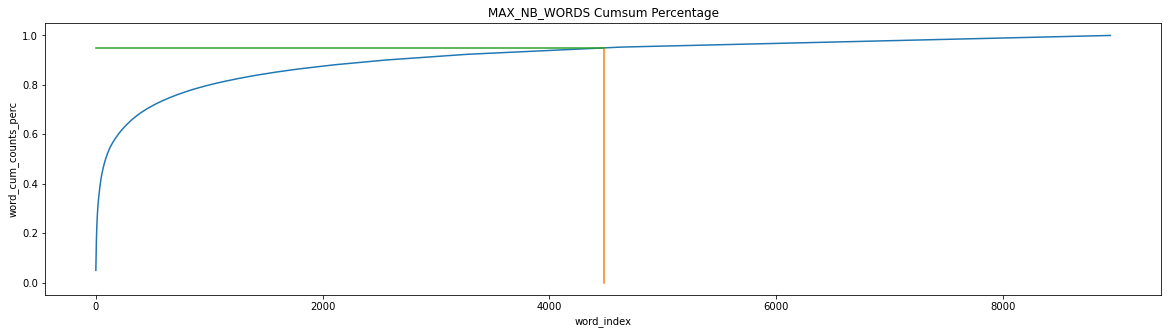

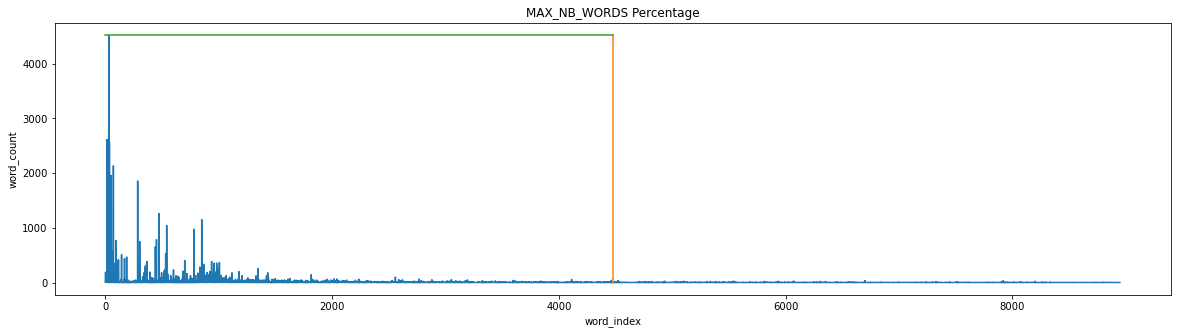

Cut index with 95.0 % of corpus:  4480 

    index  word  count
0      32   the   4516
1      15    of   2614
2      36    to   2564
3      71    is   2133
4      52     a   1957
5     285  that   1856
6      26   and   1631
7      33    in   1442
8     474    it   1260
9     850     i   1149
10    541   you   1042
11    783   not    972
12     30   are    797
13    451    be    785
14     93   for    767
15    303  this    751
16    851  have    707
17    441    as    652
18     61   but    578
19    532    if    529


4480

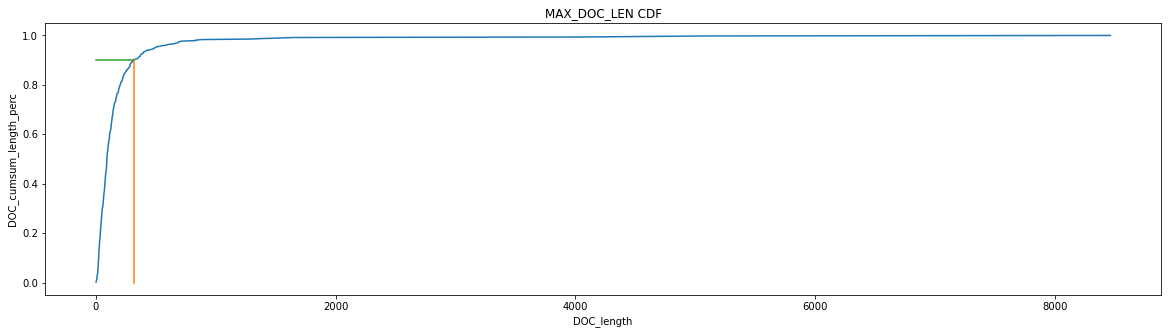

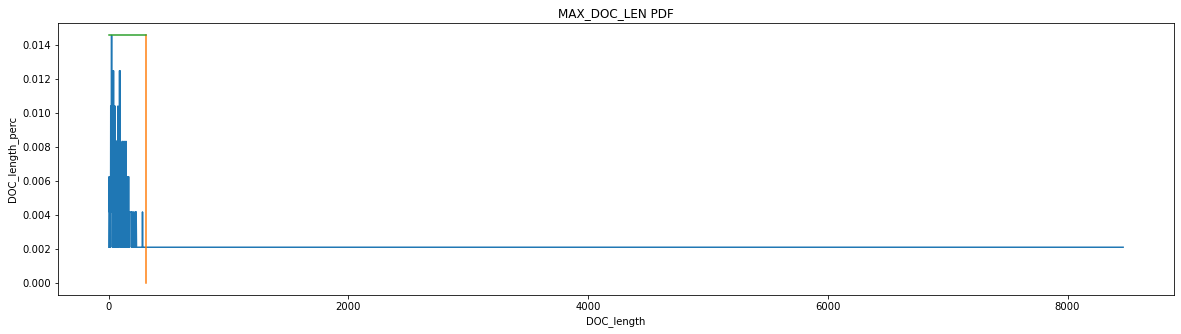

Cut index with 90.0 % of corpus:  316


316

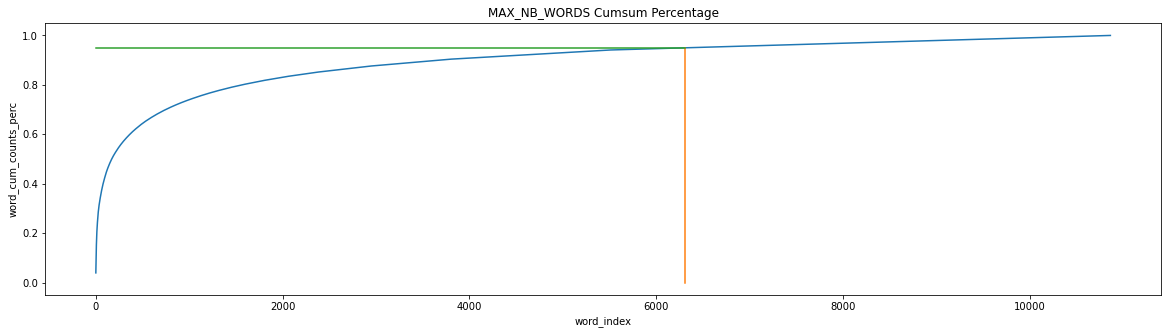

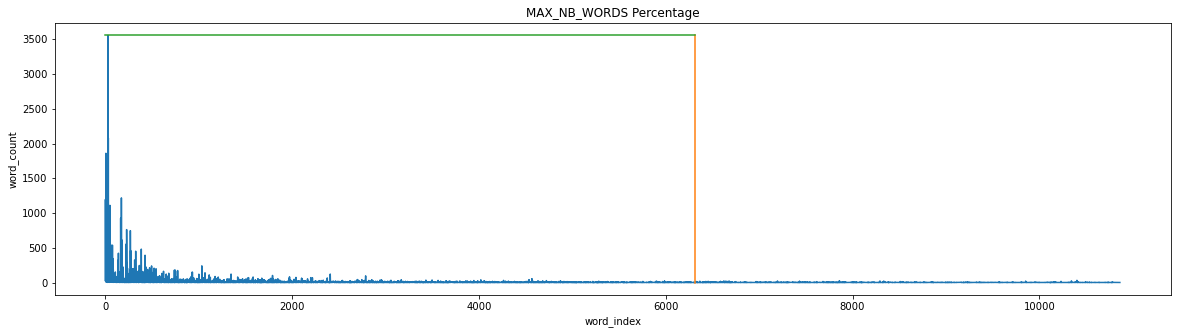

Cut index with 95.0 % of corpus:  6312 

    index   word  count
0      29    the   3556
1      32     to   2080
2      26      a   2009
3       6    and   1860
4      31     of   1764
5      24     is   1405
6     172      i   1218
7       1    for   1196
8      49     in   1111
9     164     it    926
10    228    you    762
11    268   that    747
12     43     on    680
13    180   this    611
14    222   with    553
15     55     be    553
16     76     or    538
17     41    are    515
18    177   have    492
19    385  image    481


6312

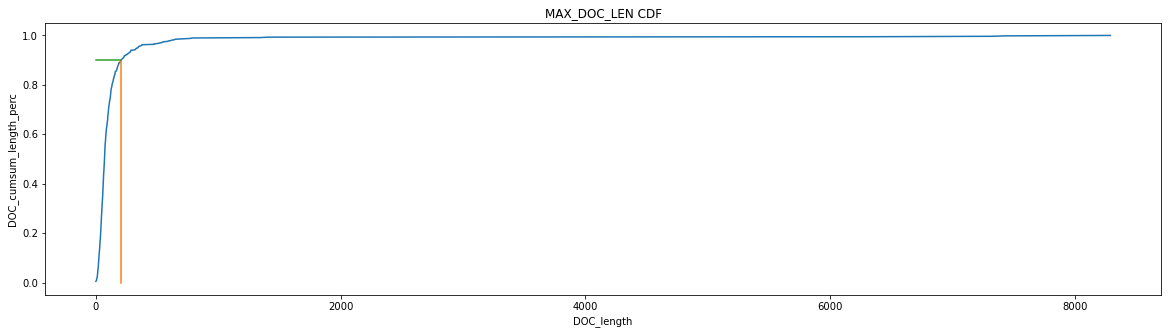

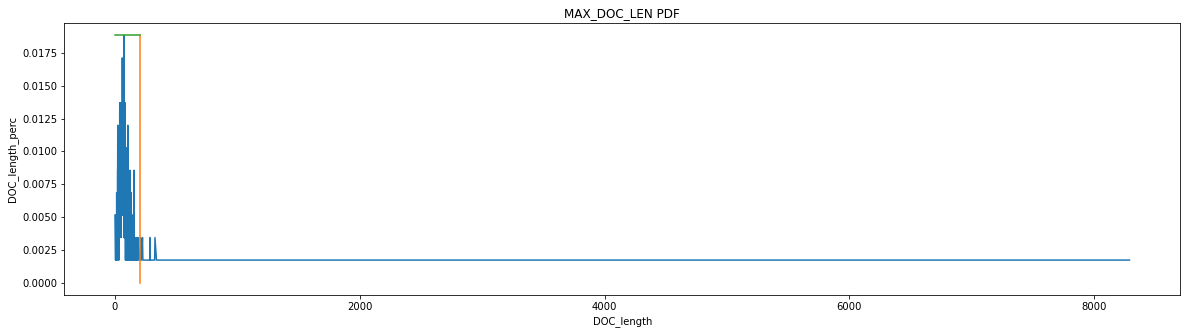

Cut index with 90.0 % of corpus:  206


206

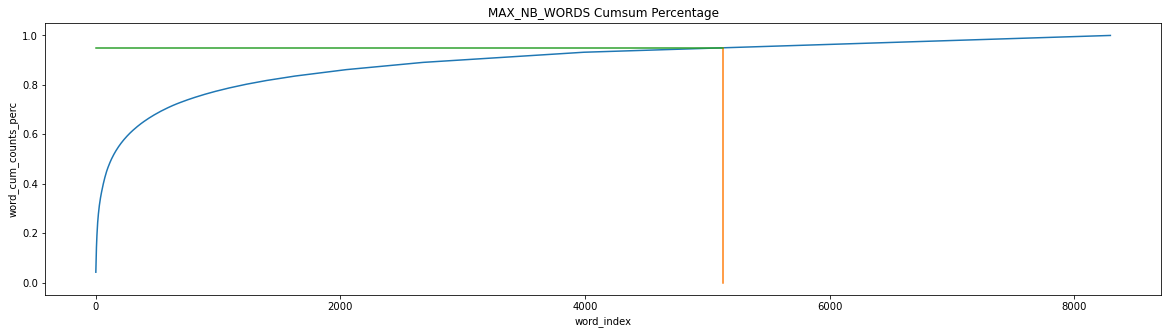

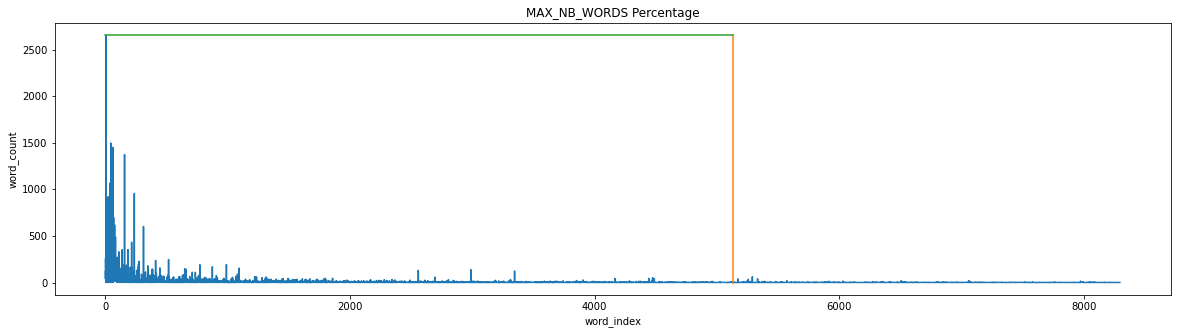

Cut index with 95.0 % of corpus:  5128 

    index     word  count
0       7      the   2651
1      45        i   1497
2      64       to   1451
3     157        a   1373
4      40      and   1068
5     237       of    955
6      24       is    920
7      23       it    800
8      68      for    699
9       6       in    686
10     76  windows    617
11    312     that    602
12     49      you    588
13     14     have    546
14     83     with    487
15     17       on    452
16    215     this    433
17     35       be    381
18     79      but    355
19    185       if    353


5128

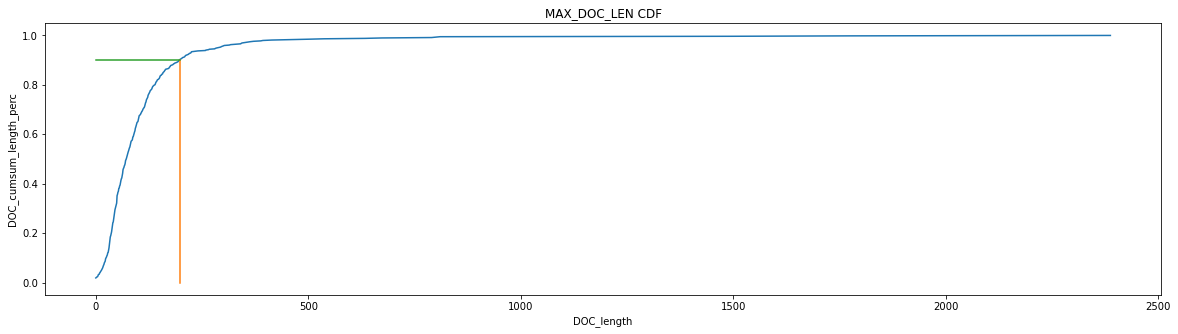

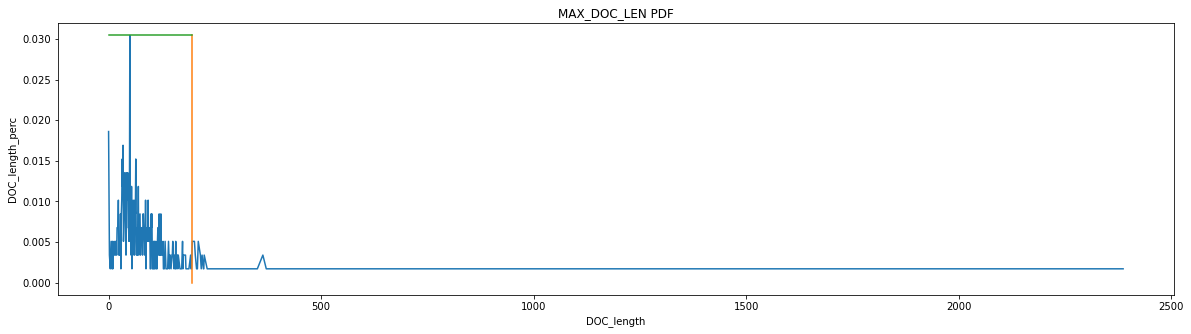

Cut index with 90.0 % of corpus:  197


197

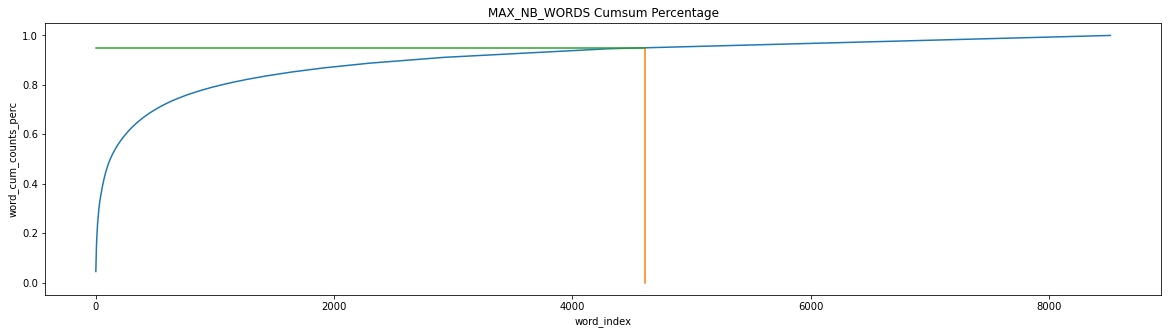

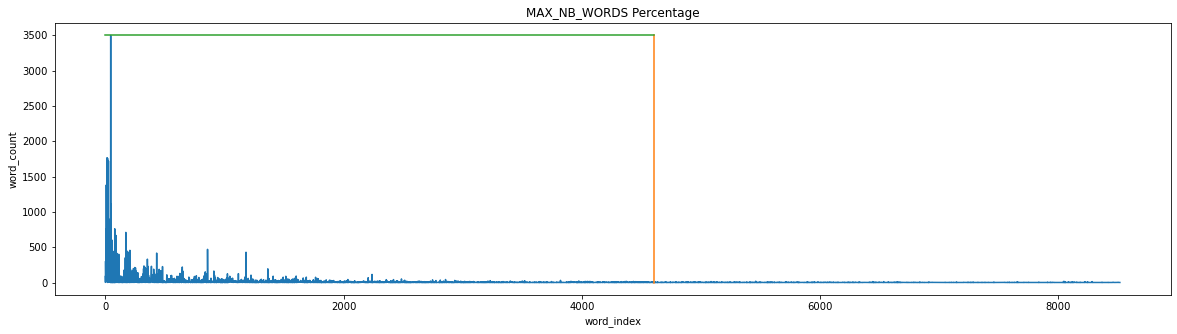

Cut index with 95.0 % of corpus:  4608 

    index   word  count
0      45    the   3498
1      14      a   1766
2      19     to   1758
3      26      i   1720
4       8    and   1381
5      47     of   1115
6      13     is   1114
7      28     it    902
8      22    for    821
9      11   that    766
10     79     in    761
11    172   with    710
12     89     on    667
13     54    you    603
14     33   have    599
15     12   this    593
16    858  drive    470
17    206      2    456
18     63      1    444
19    186     my    442


4608

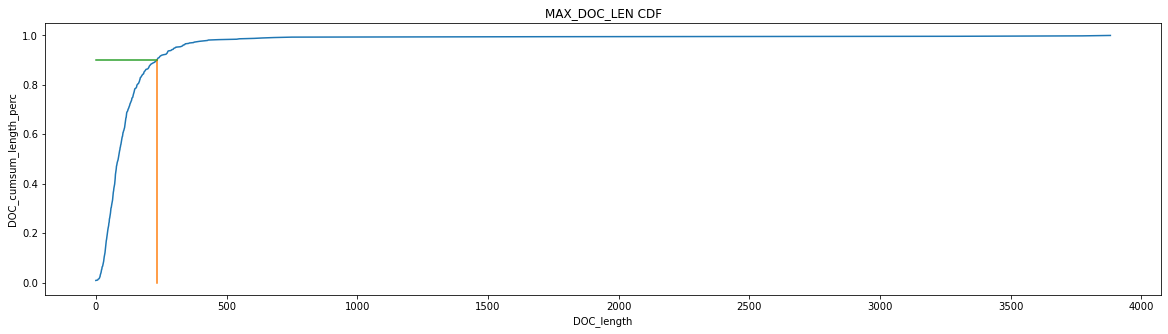

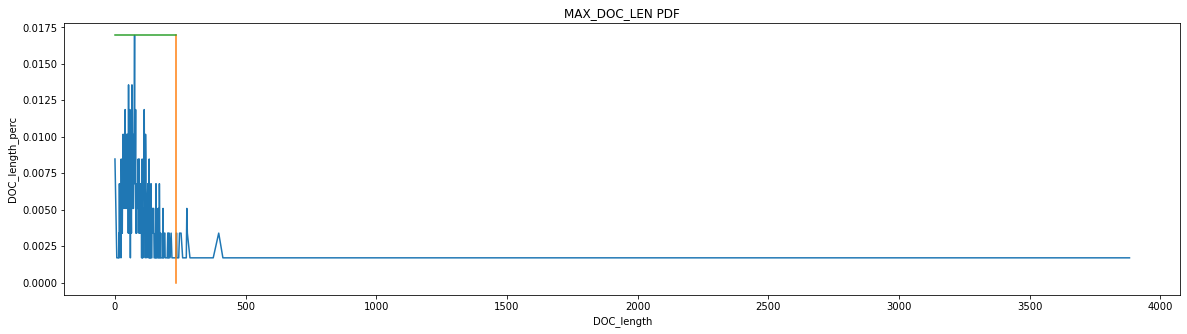

Cut index with 90.0 % of corpus:  233


233

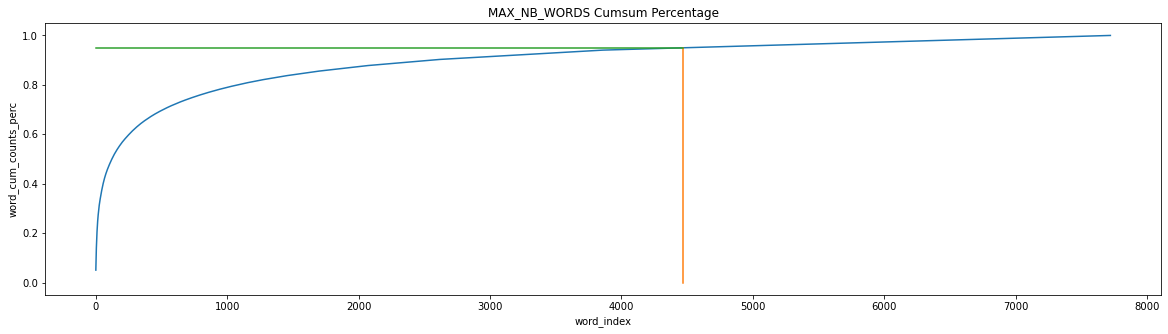

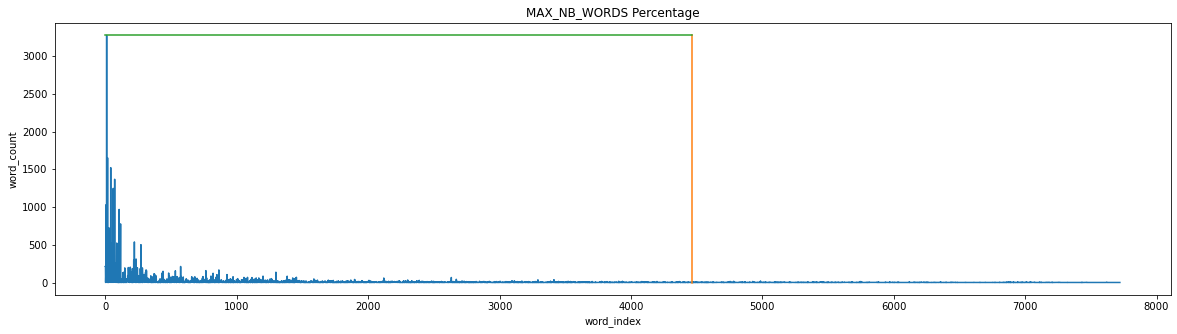

Cut index with 95.0 % of corpus:  4467 

    index  word  count
0      10   the   3275
1      17     a   1653
2      41    to   1523
3      71     i   1369
4      60   and   1248
5       5    of   1030
6     105    is    969
7      65    it    781
8     116    in    777
9      27   for    725
10     21  that    671
11     32  with    594
12    221   you    538
13     54    on    525
14     87  have    524
15    271  this    502
16     39    be    410
17     34    if    393
18     52   are    352
19    115   but    347


4467

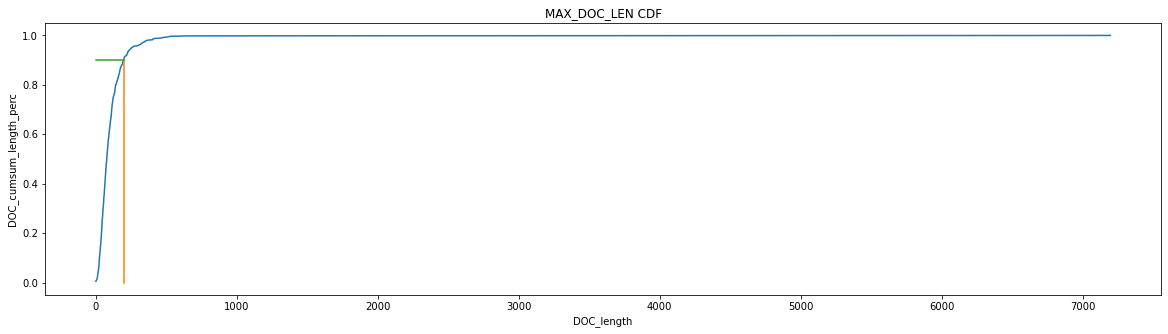

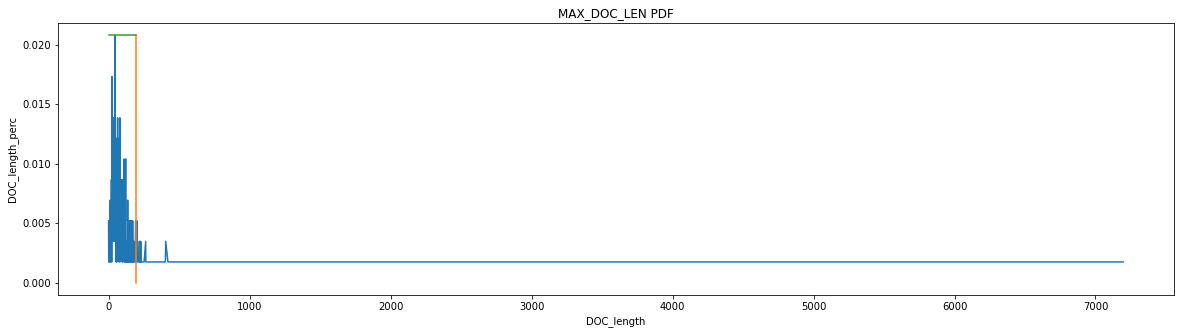

Cut index with 90.0 % of corpus:  198


198

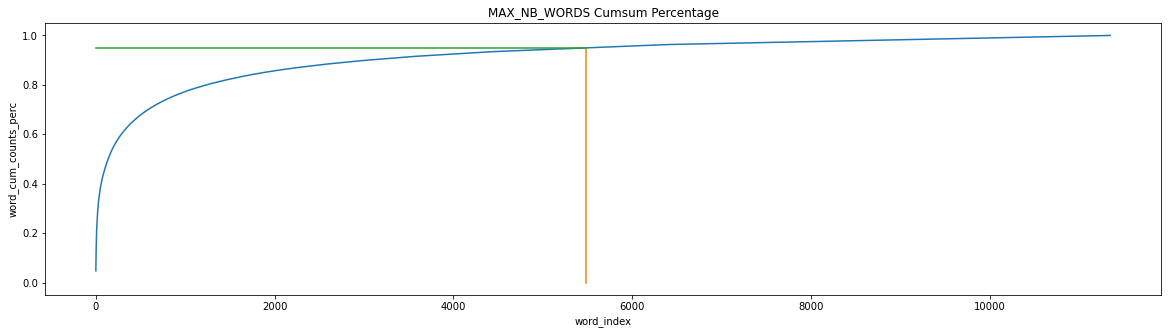

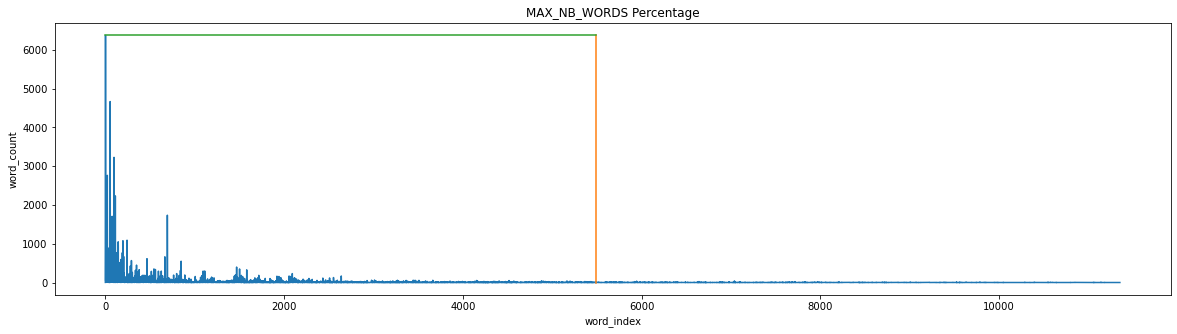

Cut index with 95.0 % of corpus:  5488 

    index  word  count
0       2   the   6371
1      54     x   4667
2      97    to   3228
3      22     a   2764
4       5   and   2291
5     112    of   2234
6      21    is   2145
7     694     i   1736
8      76    in   1707
9       8   for   1306
10    243    on   1092
11    197    it   1078
12     20  this   1051
13    144  that   1050
14    145   you    946
15     38    be    888
16      1   are    857
17    127  with    771
18    190    if    768
19    122    an    676


5488

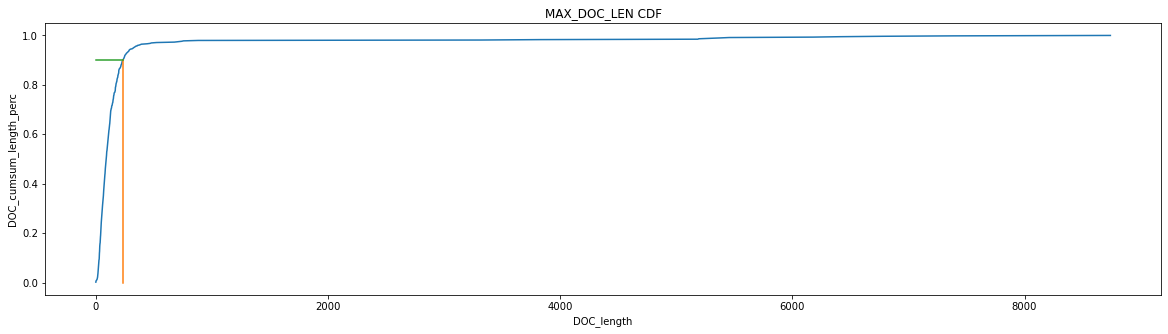

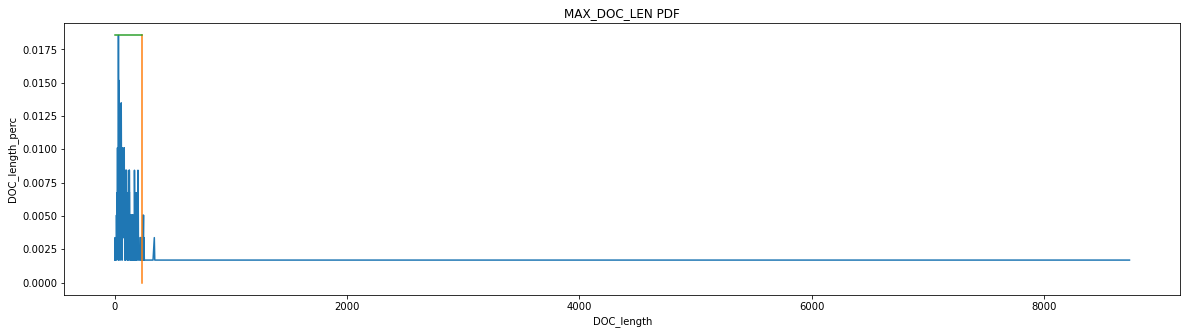

Cut index with 90.0 % of corpus:  235


235

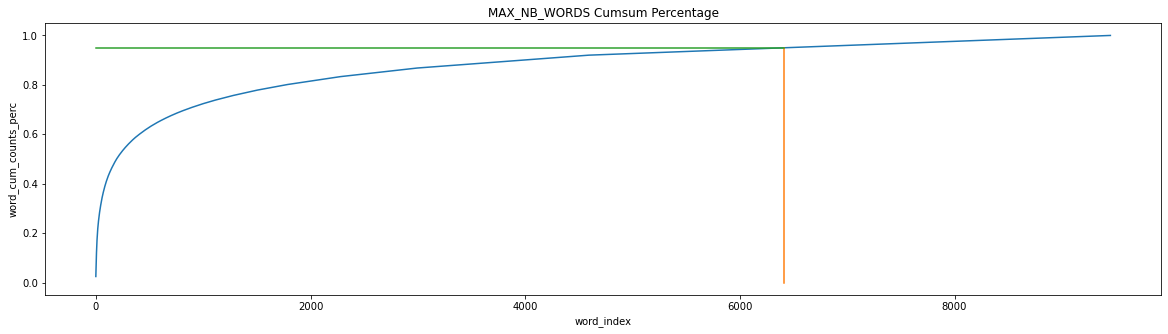

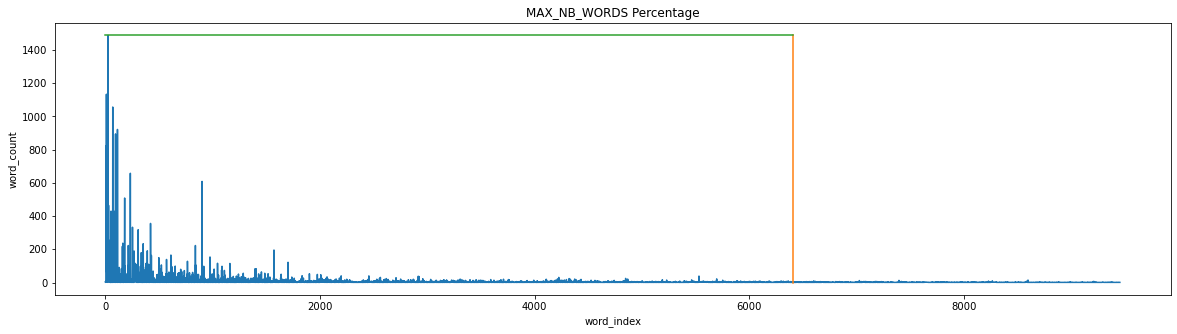

Cut index with 95.0 % of corpus:  6406 

    index  word  count
0      26   the   1488
1      10   for   1134
2      69   and   1057
3      17    to    962
4     113     a    922
5      95     1    895
6       7     i    823
7     107    of    770
8     233     2    658
9     901    00    609
10     25    in    607
11    180    is    509
12     30   you    465
13    101    it    463
14     53  with    430
15     87    or    429
16     16  have    377
17    421     3    356
18    253   are    333
19    306     5    318


6406

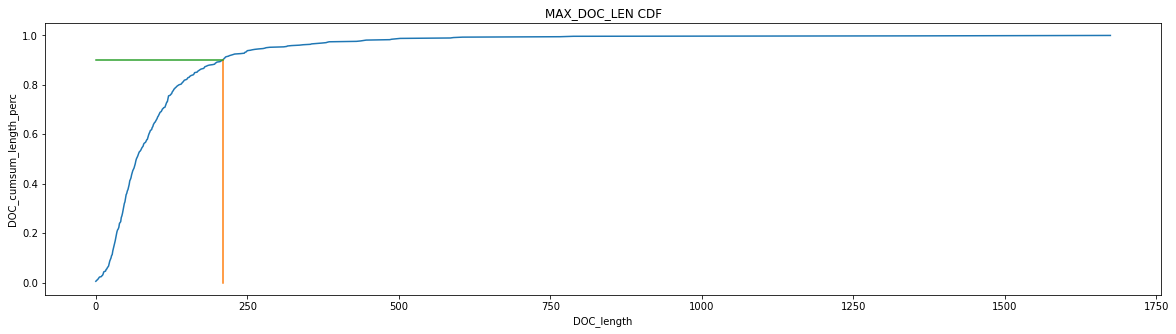

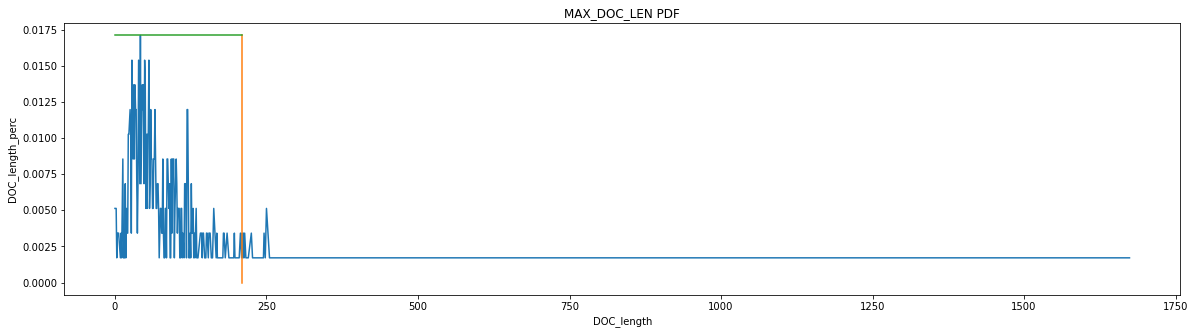

Cut index with 90.0 % of corpus:  209


209

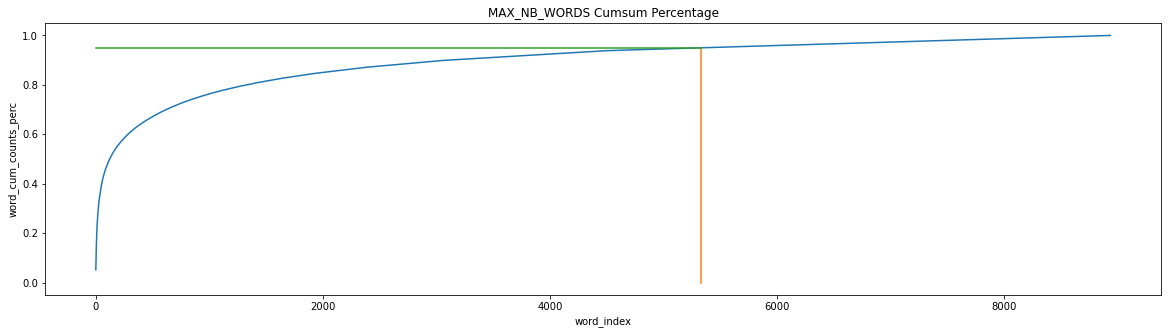

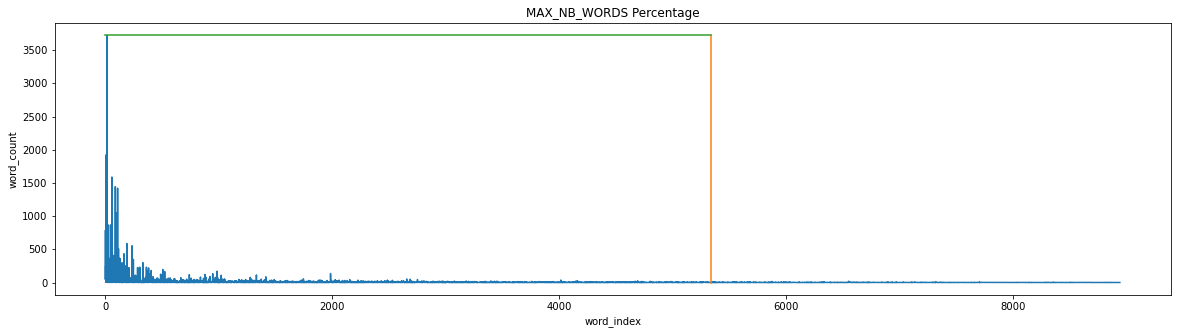

Cut index with 95.0 % of corpus:  5332 

    index  word  count
0      14   the   3721
1       8     a   1925
2      58    to   1589
3      88     i   1444
4     108   and   1421
5      11    of   1312
6     101    in   1050
7      15    is    972
8      52    it    874
9      28  that    867
10      1   you    788
11     23   for    673
12    189    on    589
13    236  have    554
14    116   are    510
15     25   car    497
16      7  with    451
17    164  this    434
18     20    be    422
19     96    my    419


5332

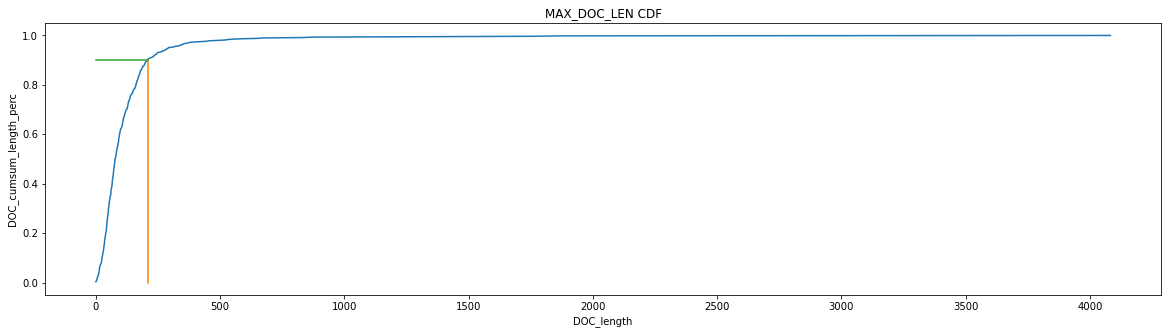

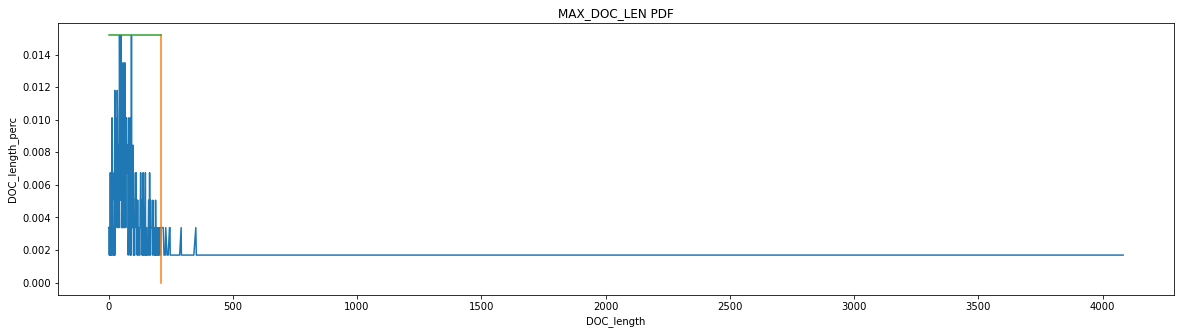

Cut index with 90.0 % of corpus:  209


209

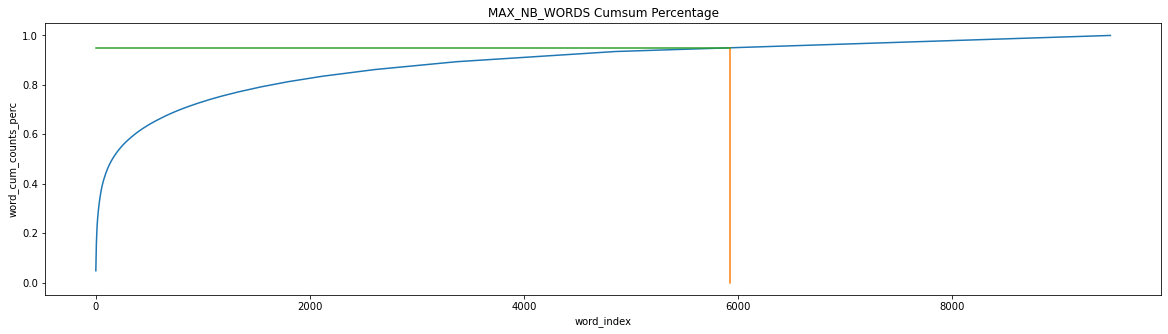

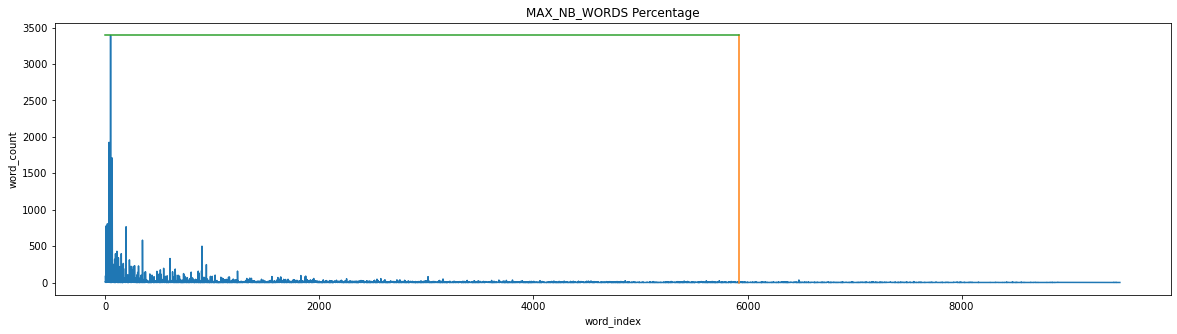

Cut index with 95.0 % of corpus:  5923 

    index  word  count
0      49   the   3393
1      35     a   1925
2      62    to   1712
3      64     i   1426
4      44   and   1368
5      40    of   1298
6      32    in    926
7      19    is    806
8       5    it    775
9     194   you    766
10     37  that    734
11     22   for    680
12    347    on    582
13    903    my    499
14    108  with    429
15     65  have    411
17    149   was    396
16     95  this    396
18    103   dod    376
19    122    be    340


5923

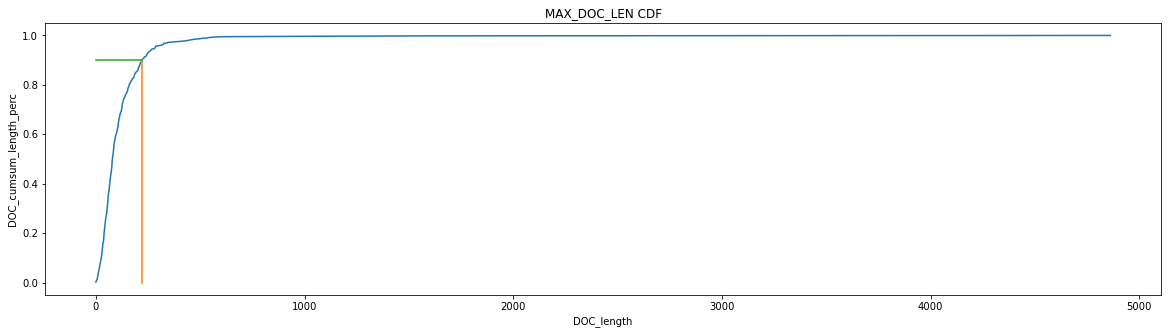

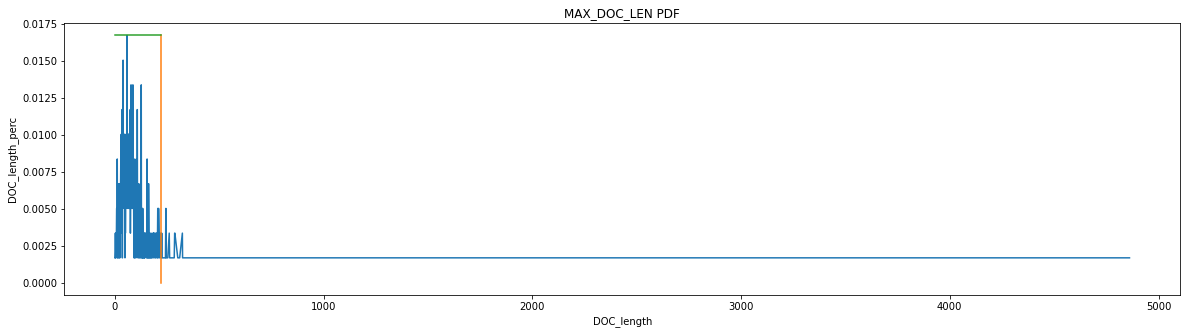

Cut index with 90.0 % of corpus:  221


221

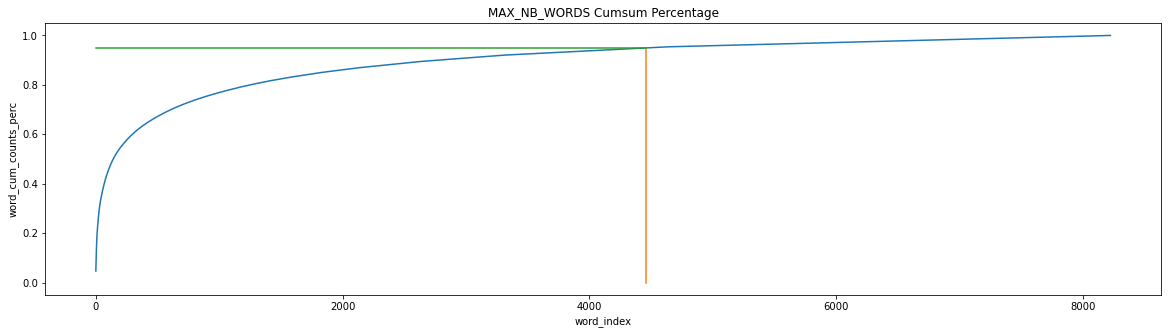

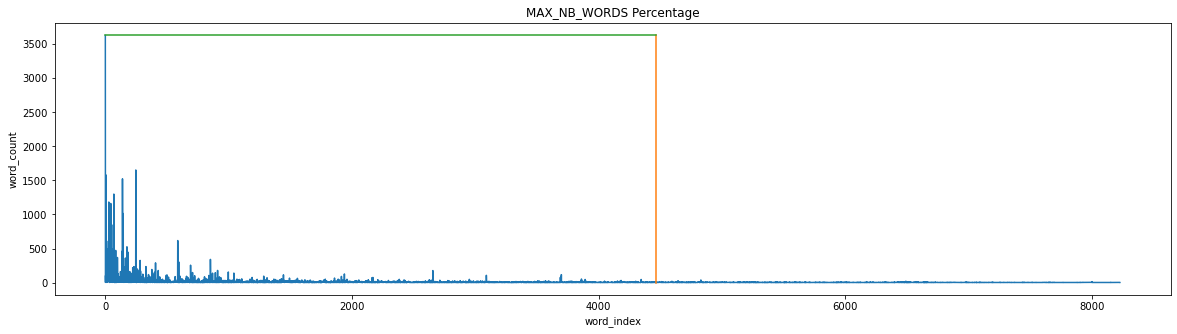

Cut index with 95.0 % of corpus:  4464 

    index  word  count
0       0   the   3631
1     247     0   1654
2       7     a   1579
3     139    to   1524
4      69   and   1300
5      28    of   1183
6      44    in   1162
7     145     i   1014
8       5    is    918
9      65  that    849
10    587    he    617
11     25   for    610
12    175     1    525
13     53  have    494
14     21    it    491
15     84   was    472
16     56    on    462
17     24   but    460
18    134  this    458
19    183    be    447


4464

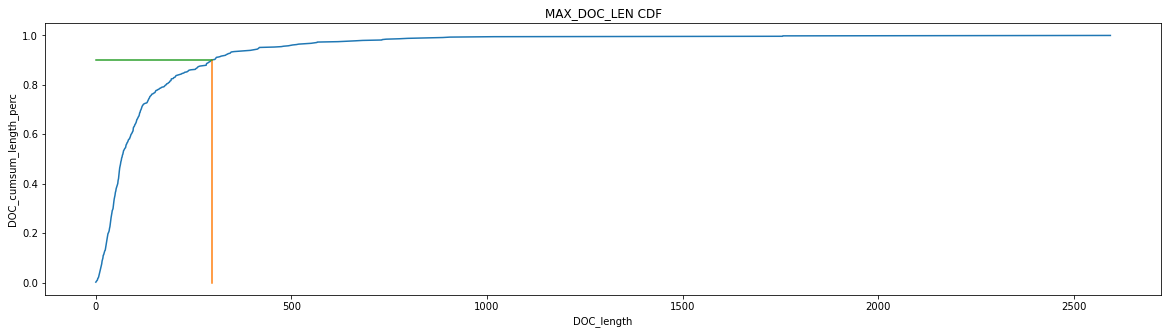

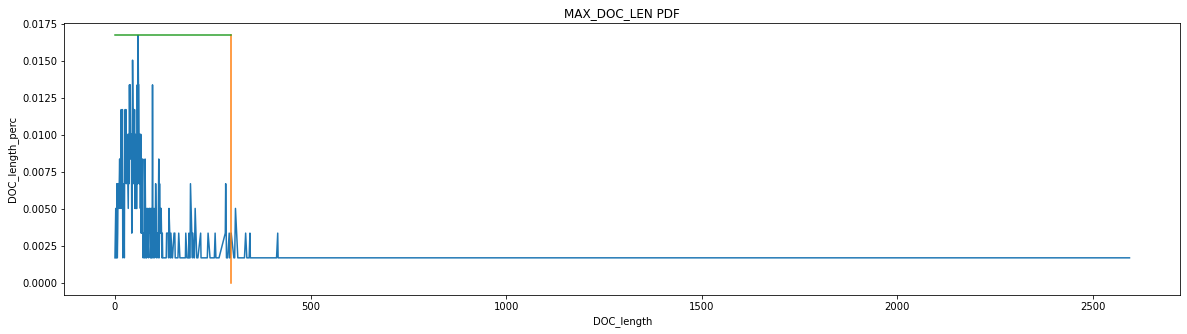

Cut index with 90.0 % of corpus:  297


297

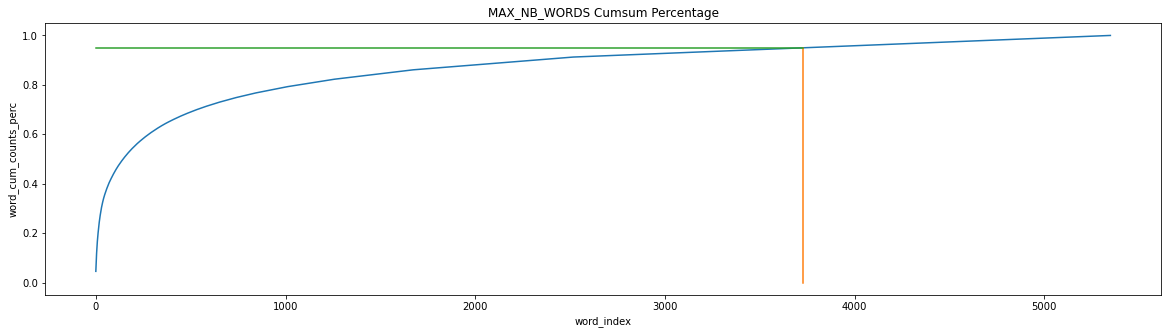

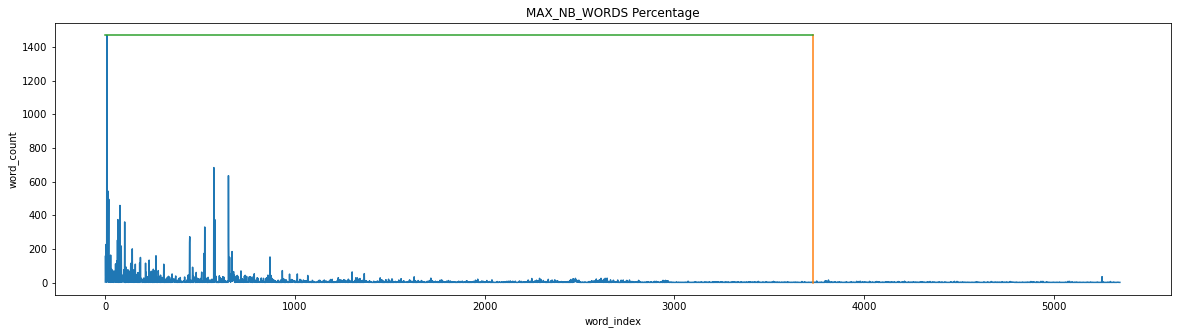

Cut index with 95.0 % of corpus:  3729 

    index  word  count
0       8   the   1468
1     572     1    683
2     649     0    635
3      13    to    544
4      18     a    495
5      77   and    458
6     577     2    374
7      66    of    374
8     102    in    360
9     524     3    330
10    445     4    272
11     10     i    266
12     17  that    264
13     64   for    252
14    444     5    237
15      6    is    229
17      4    it    225
16    650     6    225
18     84    he    217
19    142    on    200


3729

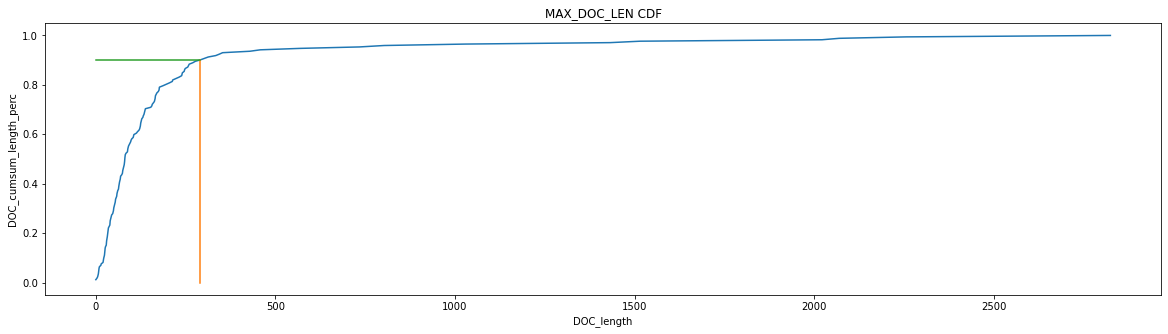

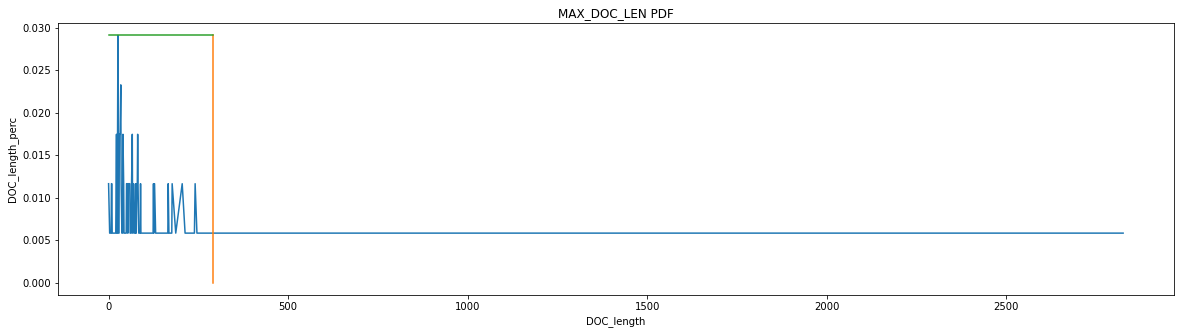

Cut index with 90.0 % of corpus:  291


291

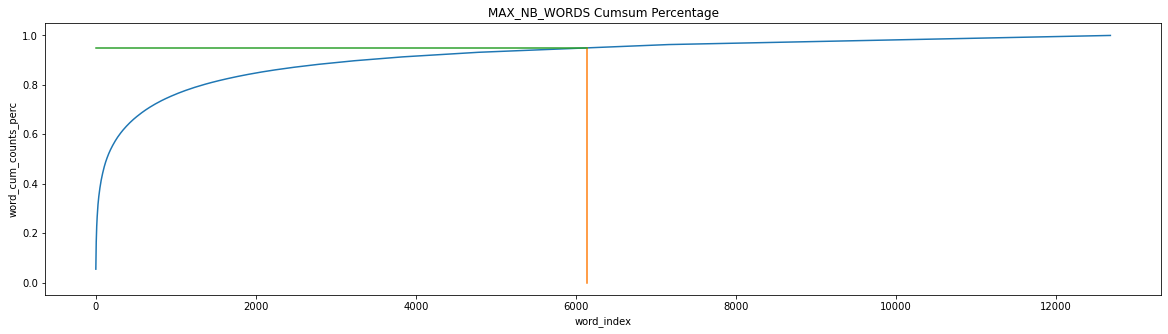

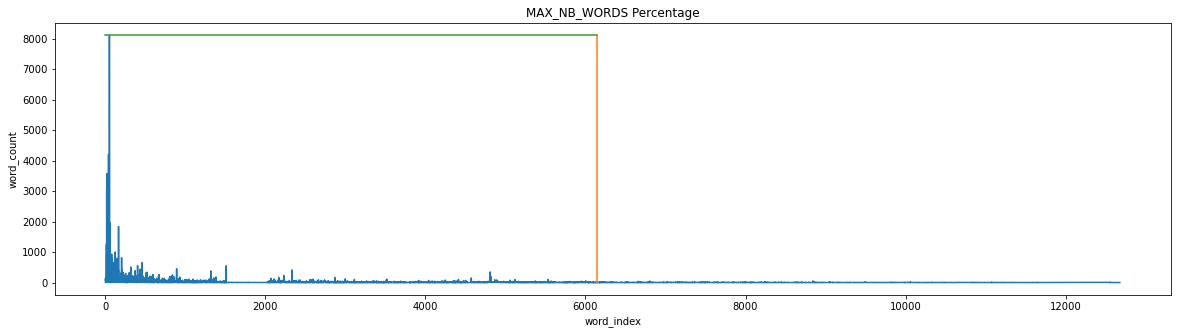

Cut index with 95.0 % of corpus:  6142 

    index  word  count
0      51   the   8112
1      40    to   4209
2      19    of   3572
3      22   and   3172
4      17     a   3105
5      16    is   2459
6      59    in   1956
7     165  that   1839
8      34    be   1495
9      30    it   1480
10     25   for   1413
11     14  this   1255
12     56     i   1233
13    123   are   1002
14     43    on    967
15     79   you    934
16     27   key    897
17     63  with    873
18    203    as    816
19     87    or    804


6142

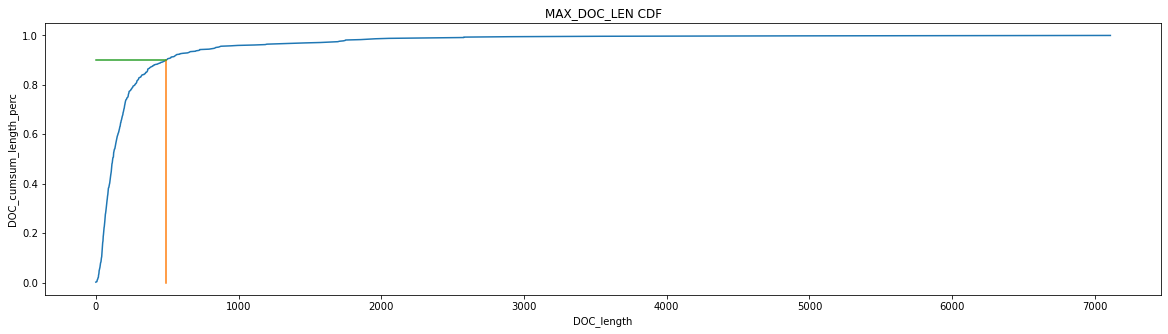

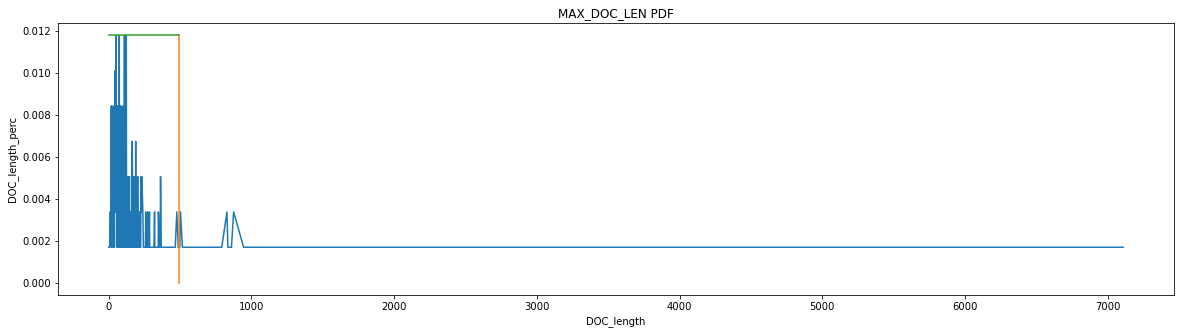

Cut index with 90.0 % of corpus:  490


490

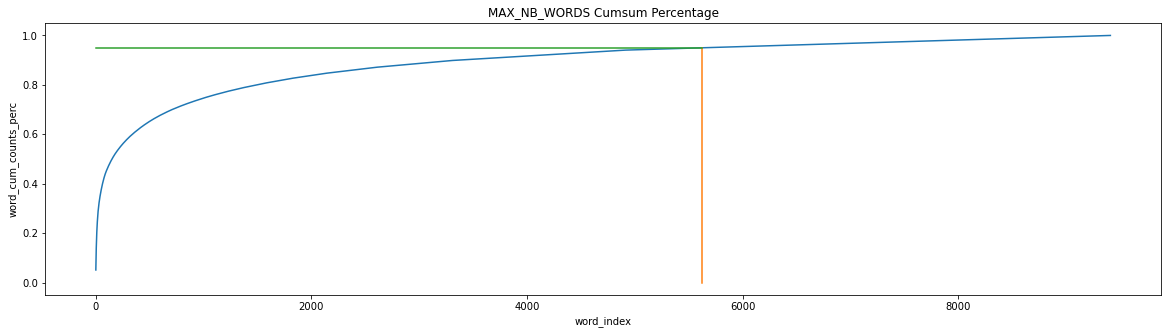

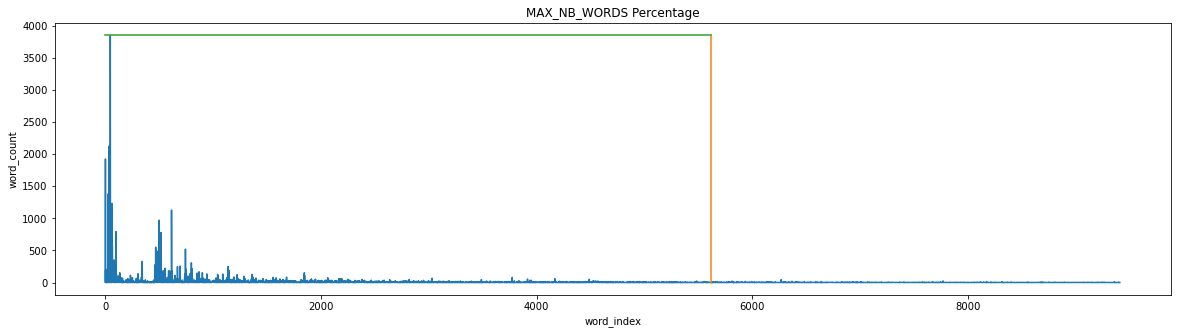

Cut index with 95.0 % of corpus:  5621 

    index  word  count
0      46   the   3854
1      34     a   2125
2       1    to   1927
3      27    of   1384
4      29   and   1276
5      61    is   1233
6     614     i   1130
7     500    in    972
8      33   for    816
9      98   you    795
10    516    it    780
11     62  that    736
12     65   are    576
13    467    be    551
14     55  this    530
15    743    on    521
16    473    or    503
17    476  with    491
18    484  have    473
19     97    if    470


5621

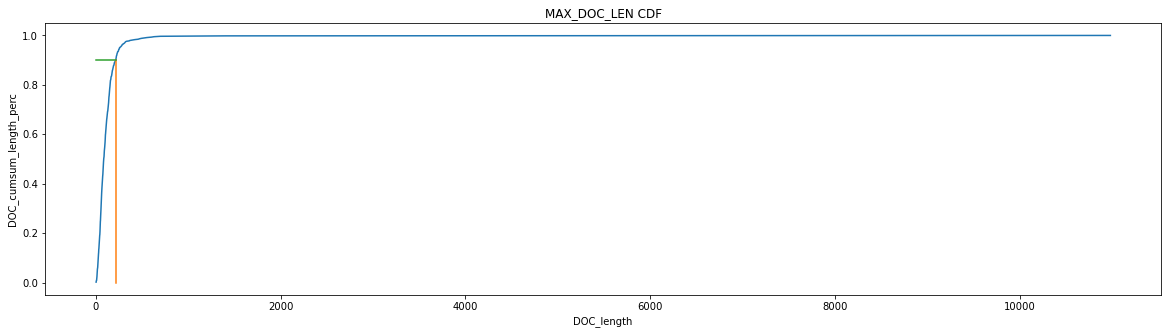

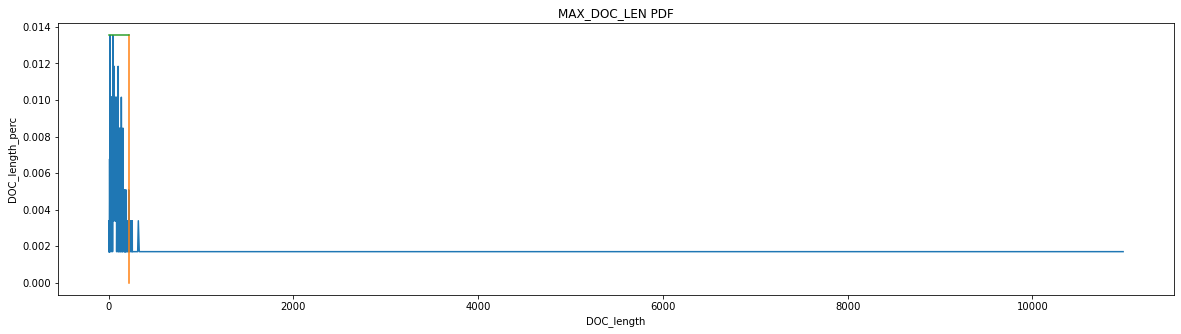

Cut index with 90.0 % of corpus:  217


217

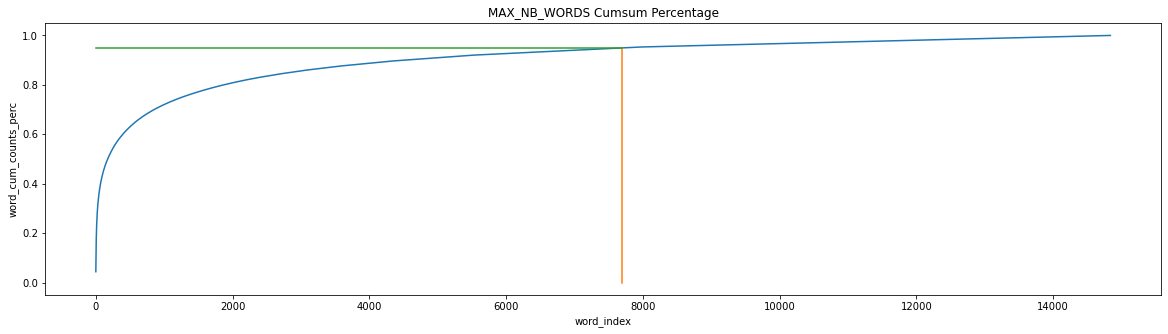

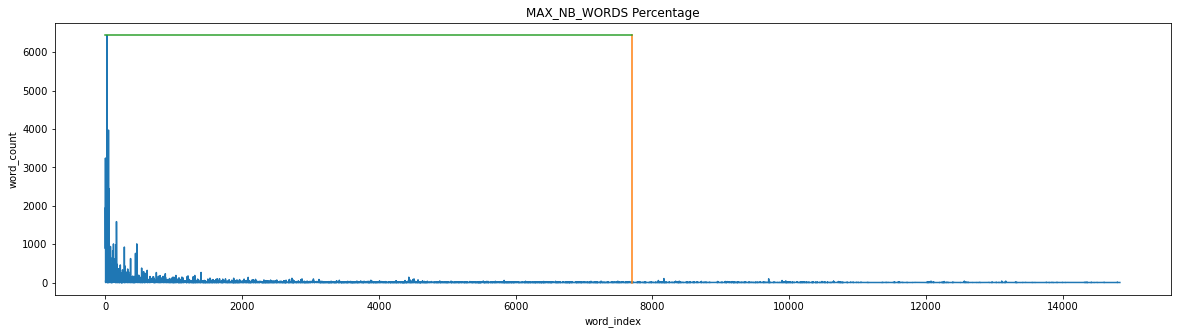

Cut index with 95.0 % of corpus:  7701 

    index  word  count
0      23   the   6439
1      46    of   3972
2      40    to   3718
3       2     a   3243
4      33   and   3163
5      49    in   2450
6      22    is   2354
7       0     i   1940
8      19  that   1813
9     163    it   1588
10     12   for   1393
11     55  this   1049
12    460   are   1007
13    119   you   1006
14    154    be    986
15     75  with    939
16    278   not    925
17      1  have    883
18    108    on    828
19    441    or    760


7701

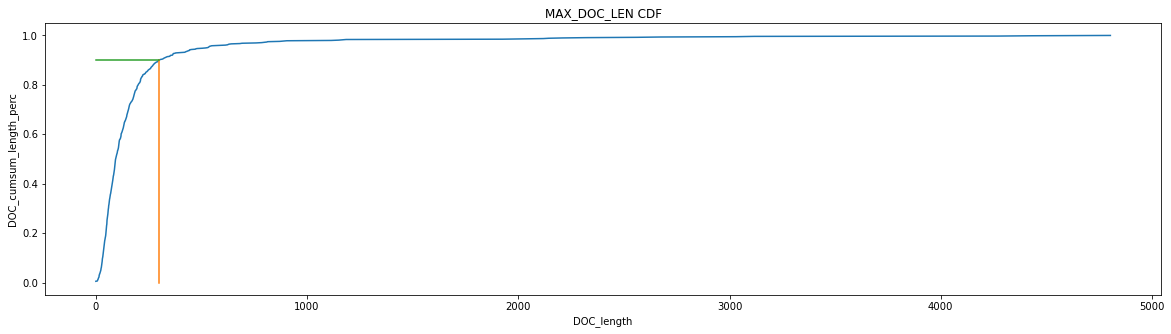

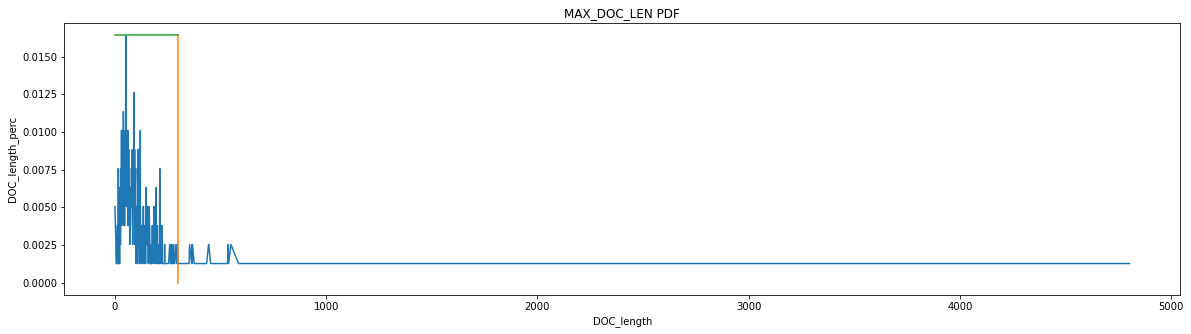

Cut index with 90.0 % of corpus:  298


298

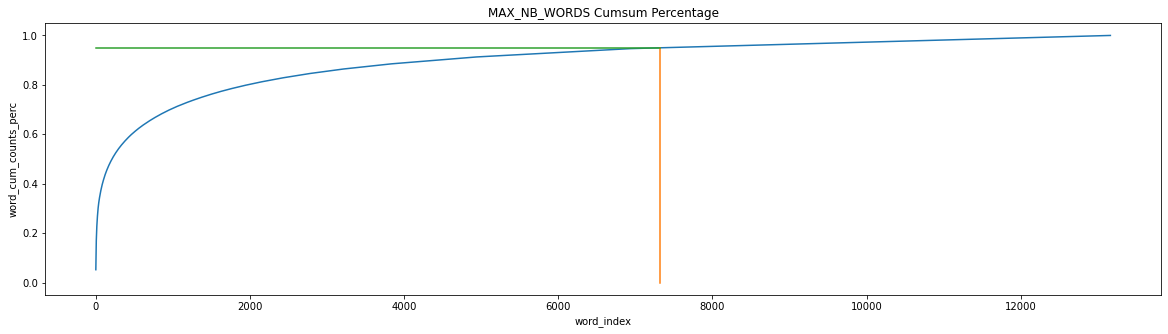

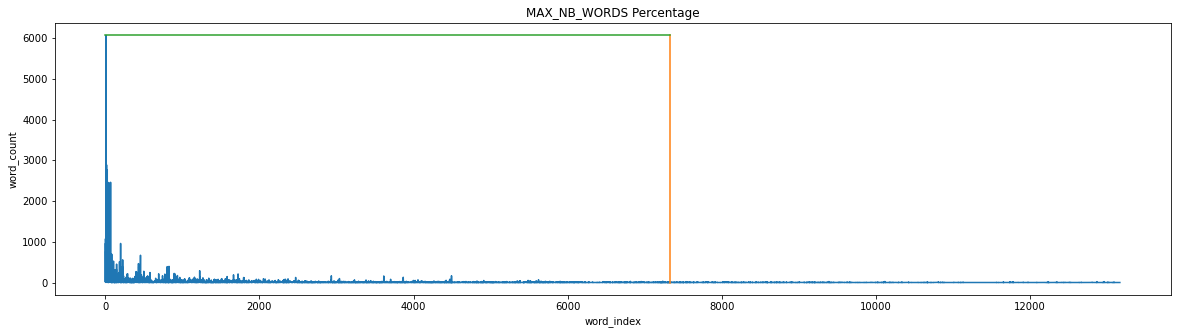

Cut index with 95.0 % of corpus:  7320 

    index   word  count
0       8    the   6068
1      16     of   2890
2      25     to   2763
3      68    and   2462
4      43      a   2457
5      27     in   1744
6      32     is   1506
7       7    for   1186
8       2   that   1074
9     198     on    960
10      0      i    948
11     11     it    934
12      3  space    913
13      5     be    766
14     83    are    697
15    456    you    670
16     71   this    668
17    225     as    557
18     22   with    548
19     13   have    543


7320

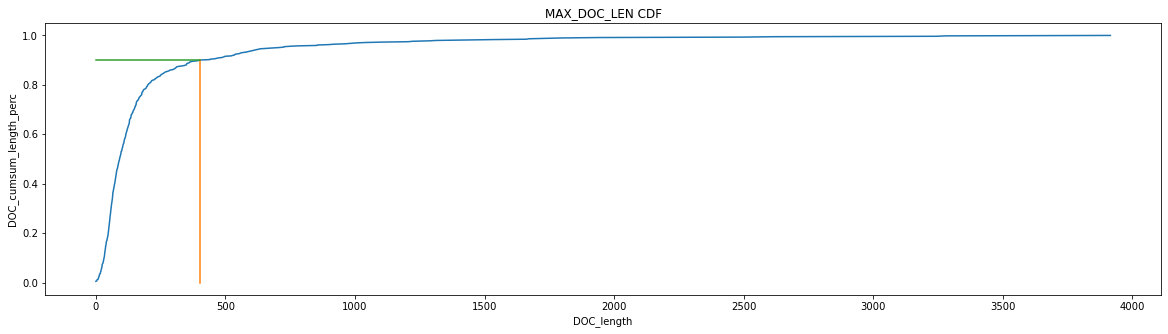

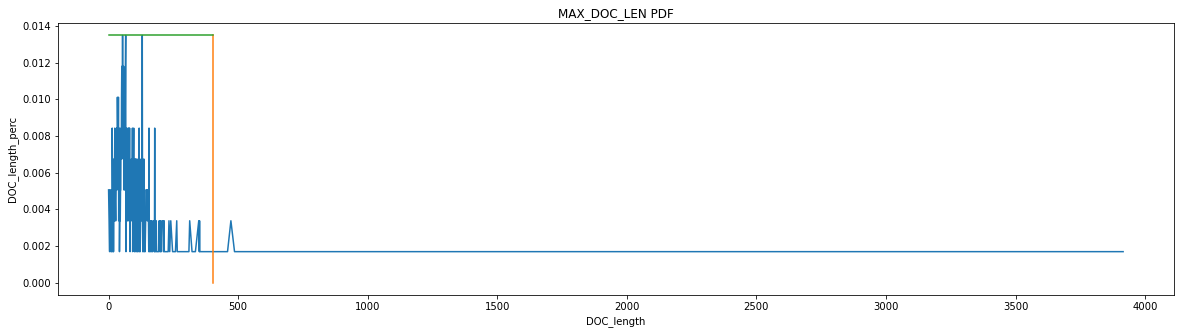

Cut index with 90.0 % of corpus:  402


402

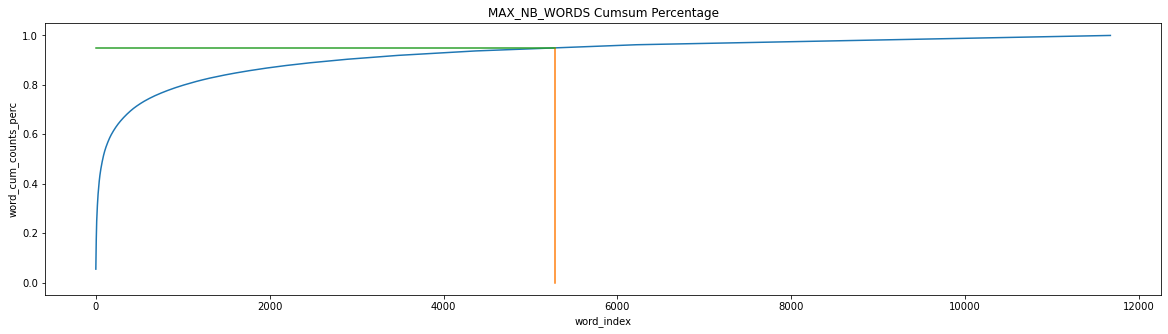

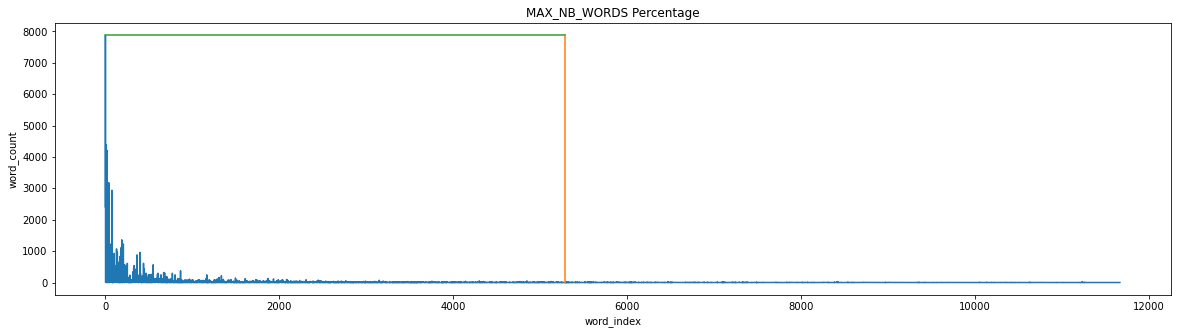

Cut index with 95.0 % of corpus:  5286 

    index  word  count
0       1   the   7871
1       5    of   4397
2      21    to   4208
3      40   and   3179
4      77    is   2941
5      16  that   2886
6      32     a   2755
7       0    in   2409
8      10     i   2372
9      13    it   1652
10     22   not   1472
11    189   you   1360
12     65   for   1230
13    207    be   1227
14     45  this   1205
15    179   are   1106
16    129    as   1072
17     25  have   1008
18    138    we    967
19    399    he    960


5286

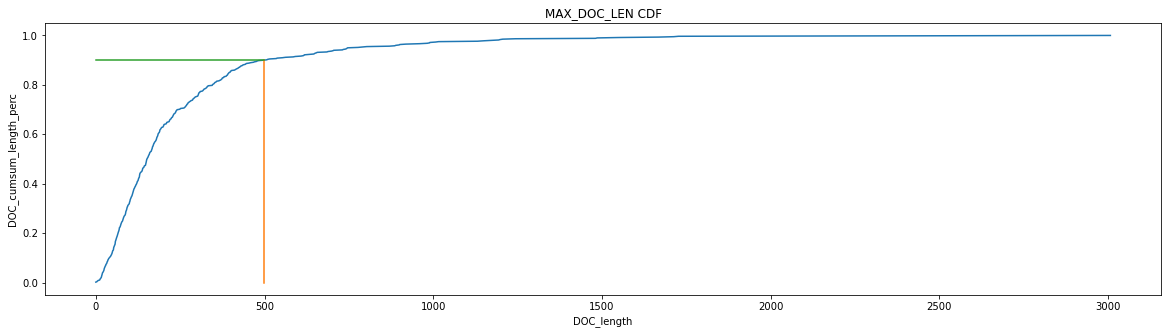

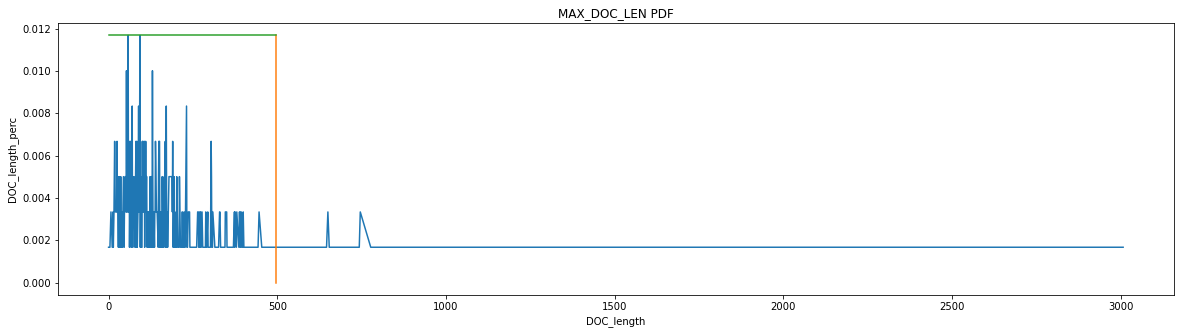

Cut index with 90.0 % of corpus:  497


497

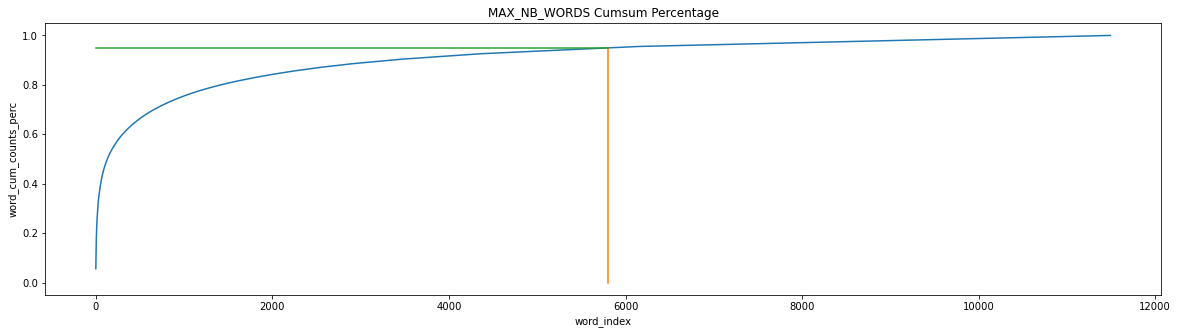

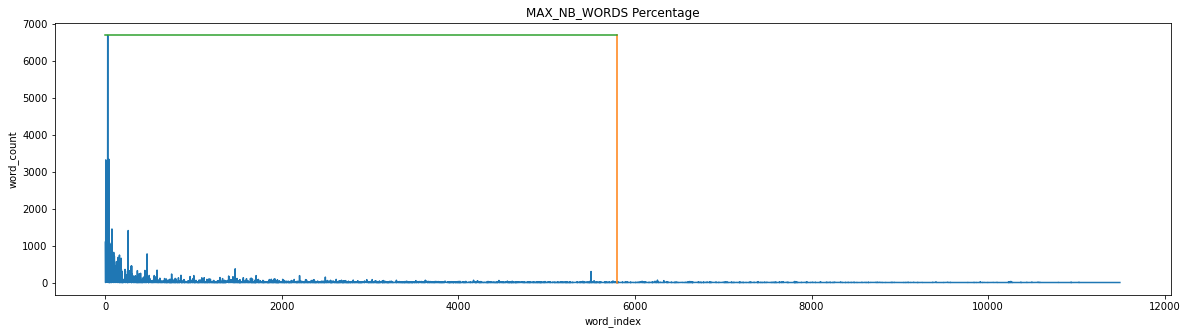

Cut index with 95.0 % of corpus:  5800 

    index  word  count
0      27   the   6698
1      41    to   3340
2       5    of   3324
3      21     a   2678
4      26   and   2363
5      43    in   1961
6      30  that   1772
7      75    is   1452
8     259     i   1410
9       0   you   1094
10     46   for   1085
11     58    it   1040
12     95  this    817
13    473  have    776
14     29    be    769
15    160    on    746
16    102   not    716
17     84    or    715
18      1   are    711
19     83    by    695


5800

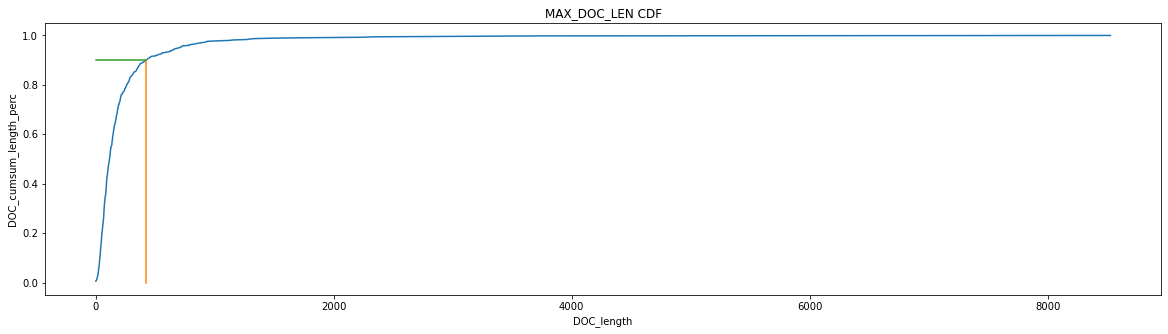

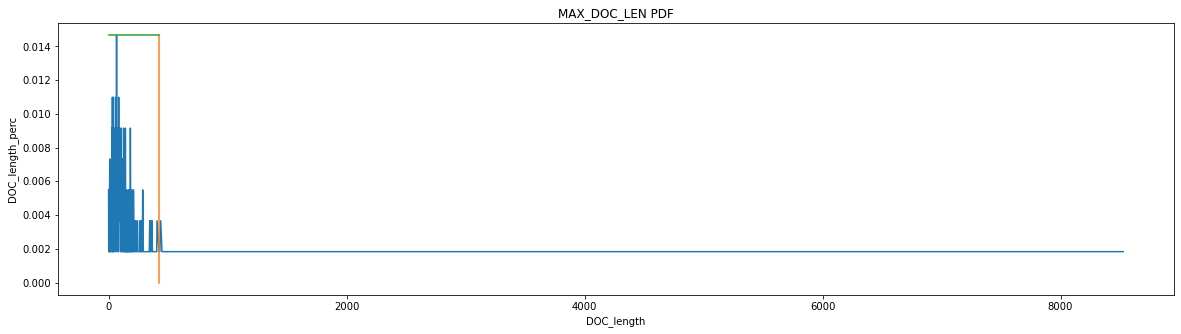

Cut index with 90.0 % of corpus:  424


424

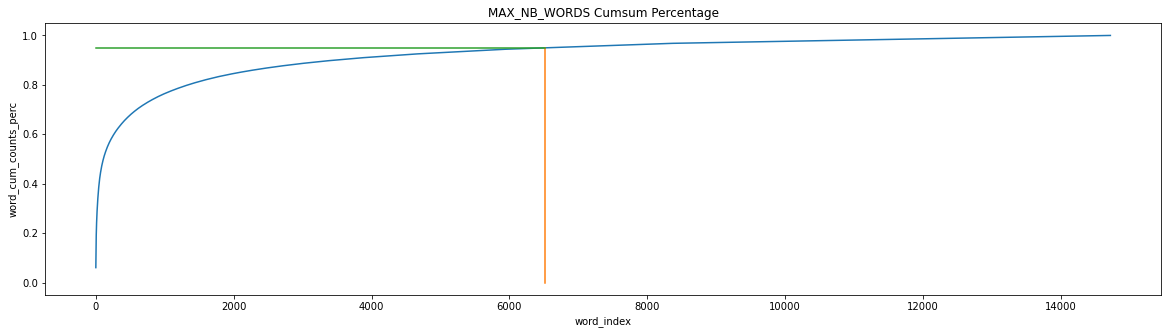

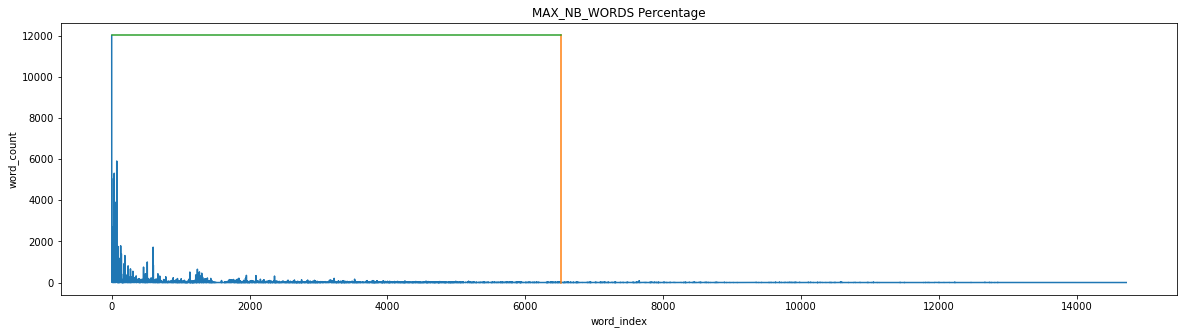

Cut index with 95.0 % of corpus:  6522 

    index  word  count
0       0   the  12026
1      73    of   5914
2      37   and   5319
3      27    to   5071
4      64    in   3919
5      53     a   3170
6      55  that   2828
7      20     i   2713
8       2    is   1934
9     130  they   1788
10     92    it   1754
11    601   was   1720
12     13   you   1631
13    140   for   1401
14     10    on   1357
15    191  were   1314
16     58   not   1236
17    121   are   1184
18     80    as   1113
19      3    by   1102


6522

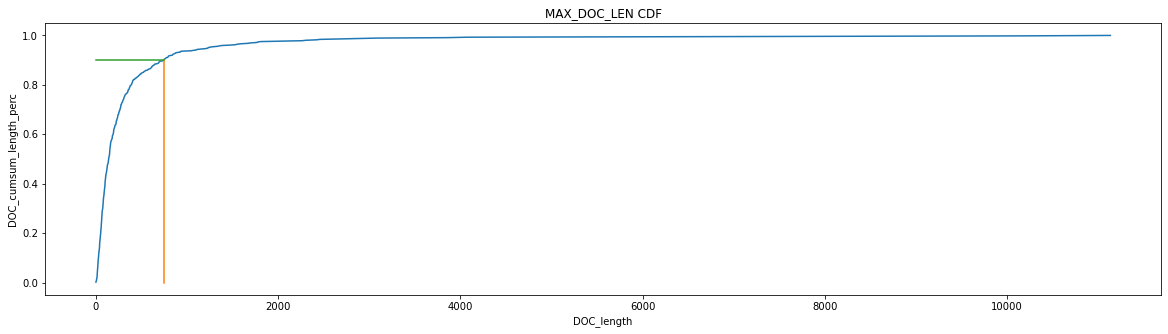

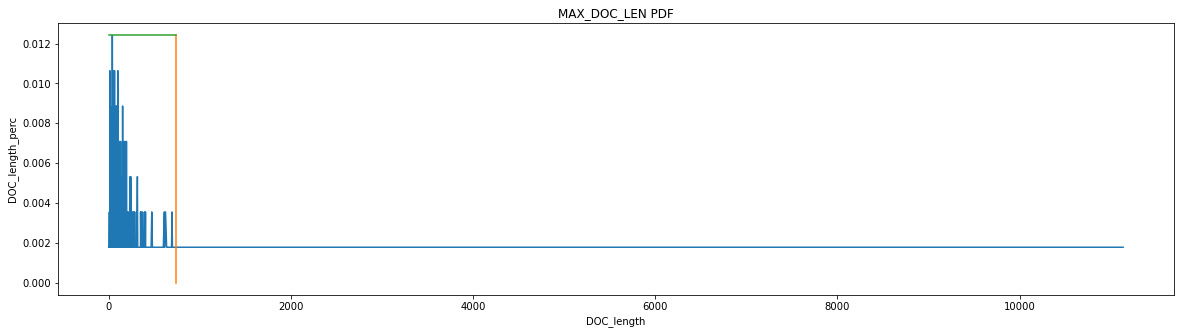

Cut index with 90.0 % of corpus:  744


744

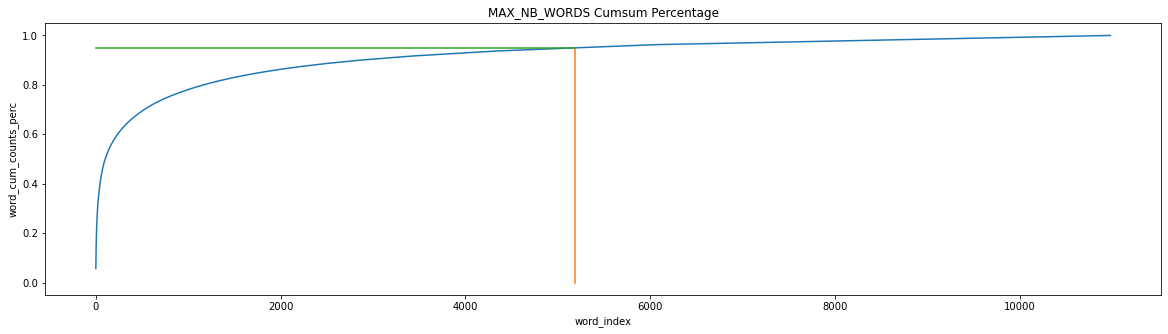

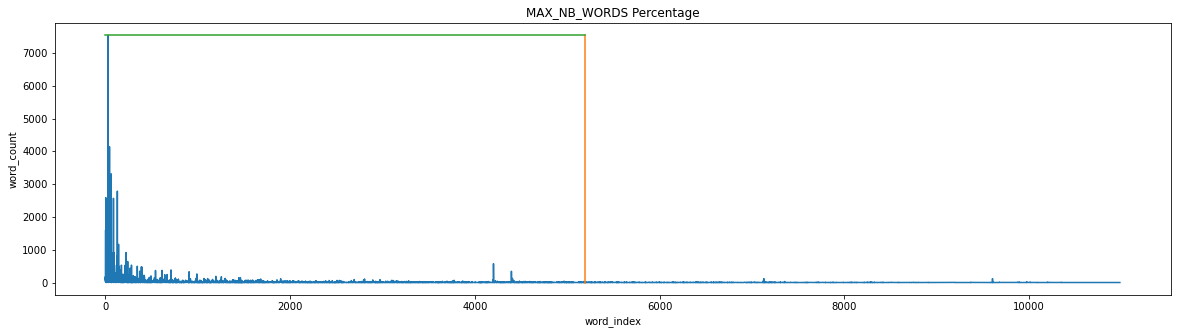

Cut index with 95.0 % of corpus:  5189 

    index  word  count
0      31   the   7533
1      45    to   4141
2      64    of   3313
3     130   and   2786
4       5  that   2588
5      88     a   2568
6      24    in   2149
7      49    is   1834
8       3     i   1604
9      36    it   1418
10     19   you   1316
11    143   for   1165
12     27  this   1053
13     26    on   1001
14     55  have    980
15    225   are    916
16     93   not    915
17     73    be    899
18    125    as    801
19     62  with    784


5189

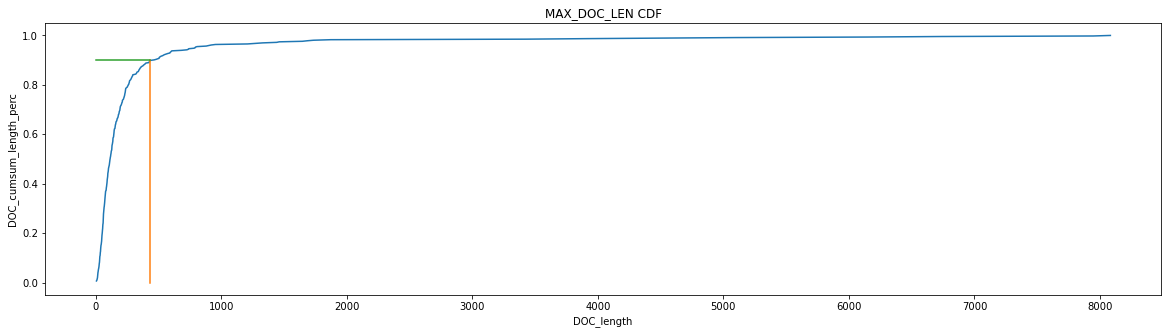

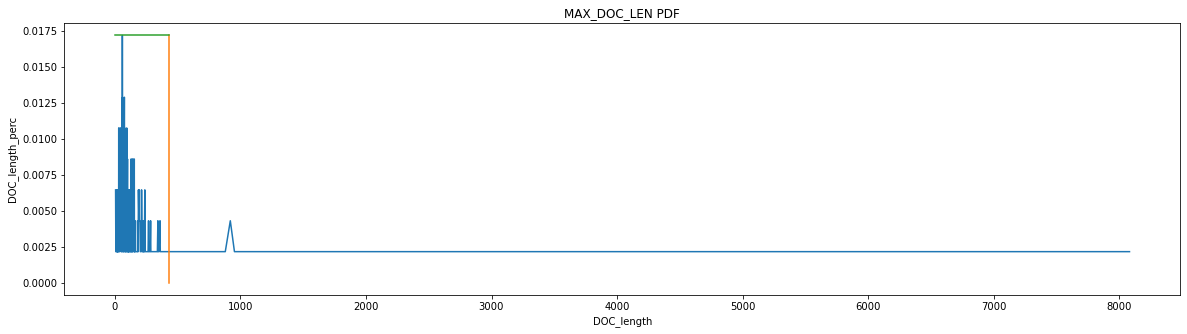

Cut index with 90.0 % of corpus:  433


433

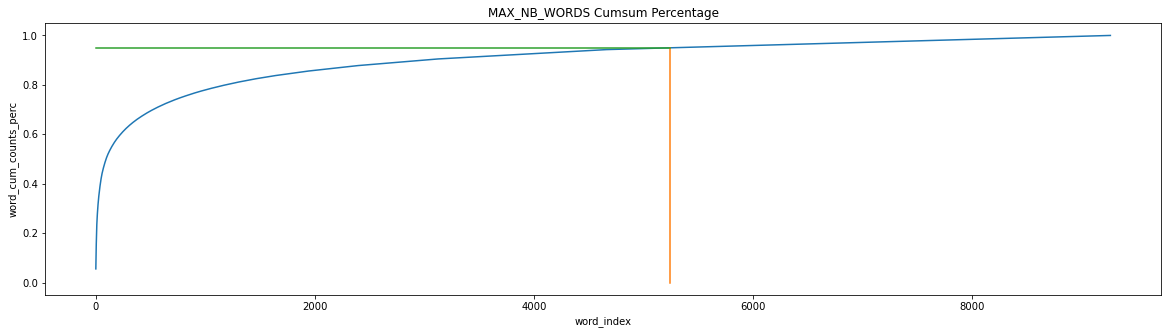

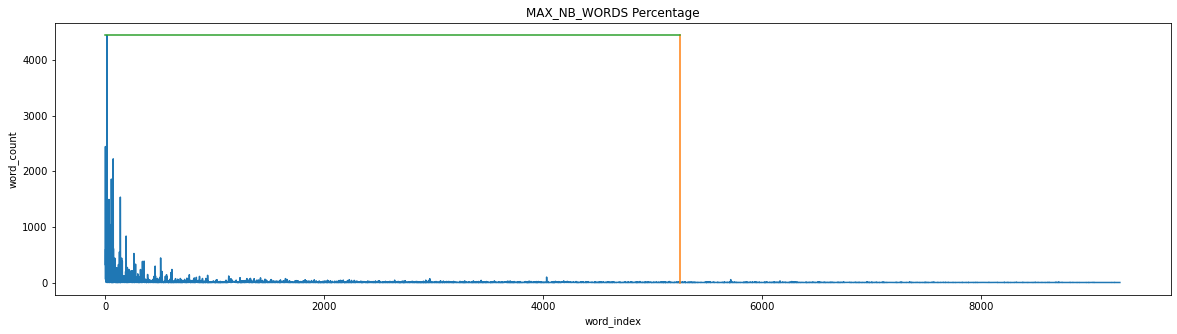

Cut index with 95.0 % of corpus:  5247 

    index  word  count
0      14   the   4441
1       1    of   2444
2      72    to   2223
3      55   and   1859
4     137  that   1535
5      33     a   1493
6      10    is   1384
7      13    in   1297
8       5     i   1199
9      47   you   1041
10    190    it    835
11     31   not    732
12     24   are    625
13     74   for    610
14      3    as    601
15     44  this    585
16    129    be    551
17    261  have    522
18    128  with    478
19    505   was    442


5247

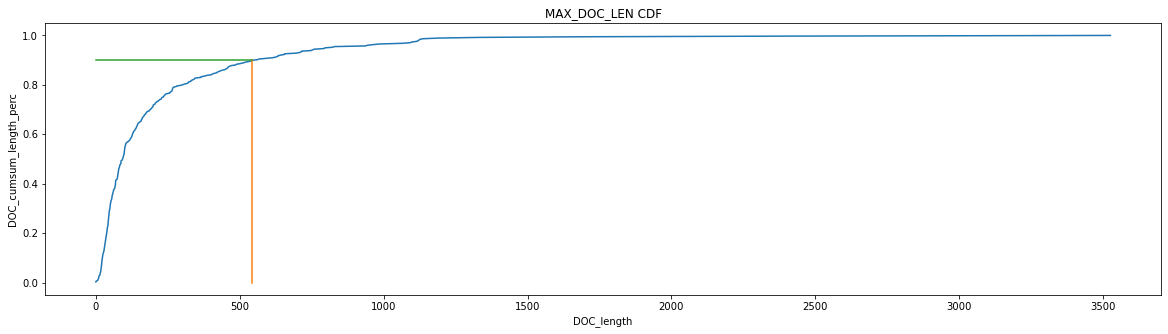

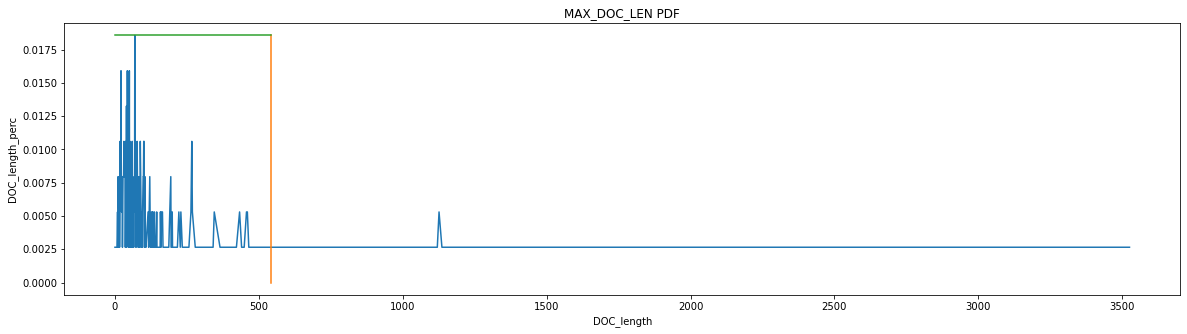

Cut index with 90.0 % of corpus:  542


542

In [109]:
for label, table in train.groupby("label"):
    corpus = table['reply']
    eda_MAX_NB_WORDS(corpus=corpus, ratio=0.95)
    eda_MAX_DOC_LEN(corpus=corpus, ratio=0.9)
#     break